### e10s-beta46-noapz: Main analysis

In [31]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Populating the interactive namespace from numpy and matplotlib


In [32]:
sc.defaultParallelism

64

In [33]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s, cumulative):
    # Normalize individual histograms
    e10s = e10s.map(lambda x: x/x.sum())
    none10s = none10s.map(lambda x: x/x.sum())
    
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
        
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    if cumulative:
        ylim = max(eTotal.cumsum().max(), nTotal.cumsum().max())
        eTotal.cumsum().plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
        nTotal.cumsum().plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
    else:
        ylim = max(eTotal.max(), nTotal.max())
        eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
        nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))],
             loc="best")

    # If there are more than 100 labels, hide every other one so we can still read them
    if len(ax.get_xticklabels()) > 100:
        for label in ax.get_xticklabels()[::2]:
            label.set_visible(False)
    
    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)

def normalize_uptime_hour(frame):
    frame = frame[frame["payload/simpleMeasurements/uptime"] > 0]
    frame = 60 * frame.apply(lambda x: x/frame["payload/simpleMeasurements/uptime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/uptime', axis=1, inplace=True)
    return frame
    
def compare_count_histograms(pings, *histograms_names):
    properties = histograms_names + ("payload/simpleMeasurements/uptime", "e10s")

    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in e10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        compare_scalars(histogram + " per hour", e10s[histogram].dropna(), none10s[histogram].dropna())

        
def compare_histograms(pings, *histogram_names):
    return compare_histograms_cdf(True, pings, *histogram_names)

def compare_histograms_cdf(cumulative, pings, *histogram_names):
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",) , with_processes=True).collect())
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    
    for histogram in none10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        has_children = np.sum(e10s[histogram + "_children"].notnull()) > 0
        has_parent = np.sum(e10s[histogram + "_parent"].notnull()) > 0
        
        if has_children and has_parent:
            compare_histogram(histogram + " (parent + children)", e10s[histogram].dropna(), none10s[histogram].dropna(), cumulative)

        if has_parent:
            compare_histogram(histogram + " (parent)", e10s[histogram + "_parent"].dropna(), none10s[histogram].dropna(), cumulative)

        if has_children:
            compare_histogram(histogram + " (children)", e10s[histogram + "_children"].dropna(), none10s[histogram].dropna(), cumulative)

def compare_scalars(metric, *groups):
    print "Median difference in {} is {:.2f}, ({:.2f}, {:.2f}).".format(metric,
                                                                        median_diff(*groups), 
                                                                        np.median(groups[0]),
                                                                        np.median(groups[1]))
    print "The probability of this effect being purely by chance is {:.2f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

#### Get e10s and non-e10s partitions

In [34]:
dataset = sqlContext.read.load("s3://telemetry-parquet/e10s_experiment/e10s_beta46_noapz@experiments.mozilla.org/v20160320", "parquet")

What are the branches, and how many clients do we have in each branch?

In [35]:
dataset.select("experimentBranch").distinct().take(50)

[Row(experimentBranch=u'force-disabled'),
 Row(experimentBranch=u'first-session-experiment'),
 Row(experimentBranch=u'experiment-addon-user'),
 Row(experimentBranch=u'experiment-no-addons'),
 Row(experimentBranch=u'control-addon-user'),
 Row(experimentBranch=u'control-no-addons'),
 Row(experimentBranch=u'user-disabled'),
 Row(experimentBranch=u'first-session-control')]

In [36]:
dataset.filter(dataset["experimentBranch"] == "experiment-no-addons").count()

191676

In [37]:
dataset.filter(dataset["experimentBranch"] == "control-no-addons").count()

207830

Sample by clientId; `sampled` is a small sample suitable for most measures, while `big_sampled` is a bigger sample used for when the small sample isn't statistically significant enough (such as for the slow script measures):

In [38]:
sampled = dataset.filter(dataset.sampleId <= 6).filter((dataset.experimentBranch == "experiment-no-addons") | (dataset.experimentBranch == "control-no-addons"))
big_sampled = dataset.filter(dataset.sampleId <= 50).filter((dataset.experimentBranch == "experiment-no-addons") | (dataset.experimentBranch == "control-no-addons"))

In [39]:
sampled.count(), big_sampled.count()

(28089, 204116)

How many clients have a mismatching experiment state?

In [40]:
def e10s_status_mismatch(row):
    branch_status = True if row.experimentBranch == "experiment-no-addons" else False
    e10sEnabled = json.loads(row.settings)["e10sEnabled"]
    return (row.experimentBranch, branch_status != e10sEnabled)

In [41]:
sampled.rdd.map(e10s_status_mismatch).reduceByKey(lambda x, y: x + y).collect()

[(u'control-no-addons', 0), (u'experiment-no-addons', 0)]

Transform Dataframe to RDD of pings

In [42]:
def row_2_ping(row):
    ping = {"payload": {"simpleMeasurements": json.loads(row.simpleMeasurements),
                        "histograms": json.loads(row.histograms),
                        "keyedHistograms": json.loads(row.keyedHistograms),
                        "childPayloads": json.loads(row.childPayloads),
                        "threadHangStats": json.loads(row.threadHangStats)},
           "e10s": True if row.experimentBranch == "experiment-no-addons" else False}
    return ping

In [43]:
subset = sampled.rdd.map(row_2_ping)
big_subset = big_sampled.rdd.map(row_2_ping)

In [44]:
def add_gecko_activity(ping):
    uptime = ping["payload"]["simpleMeasurements"].get("uptime", -1)
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        child_uptime = payload["simpleMeasurements"].get("uptime", -1)
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)

## 1. Generic stuff

In [45]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/firstLoadURI",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/sessionRestoreInit",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "parent_hangs_per_minute",
    "child_hangs_per_minute"]).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

(13365, 14724)

#### a) Startup time evaluation:

In [46]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

Median difference in startup time is -77.00, (4391.00, 4468.00).
The probability of this effect being purely by chance is 0.26.


In [47]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstLoadURI"].dropna(), nSimple["payload/simpleMeasurements/firstLoadURI"].dropna())

Median difference in startup time is 4562.00, (9173.00, 4611.00).
The probability of this effect being purely by chance is 0.00.


#### b) Shutdown time evaluation:

In [48]:
compare_scalars("shutdown duration", eSimple["payload/simpleMeasurements/shutdownDuration"].dropna(), nSimple["payload/simpleMeasurements/shutdownDuration"].dropna())

Median difference in shutdown duration is 34.00, (1190.00, 1156.00).
The probability of this effect being purely by chance is 0.02.


#### c) Animation smoothness:

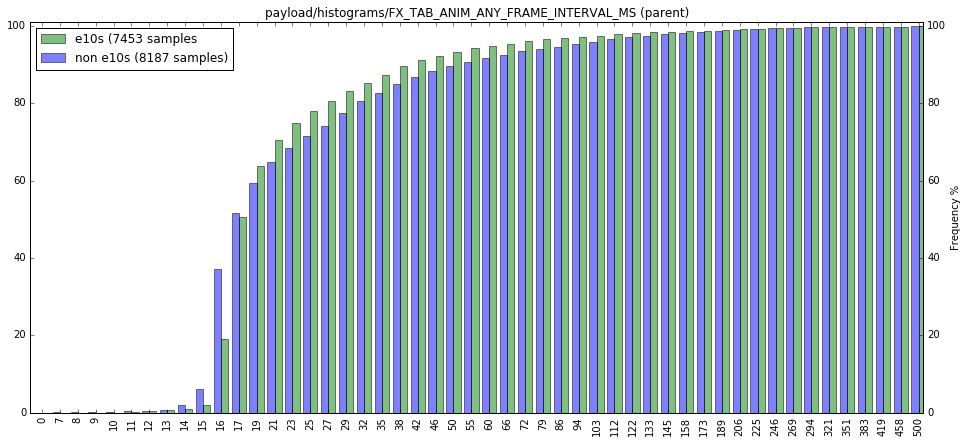

The probability that the distributions for payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


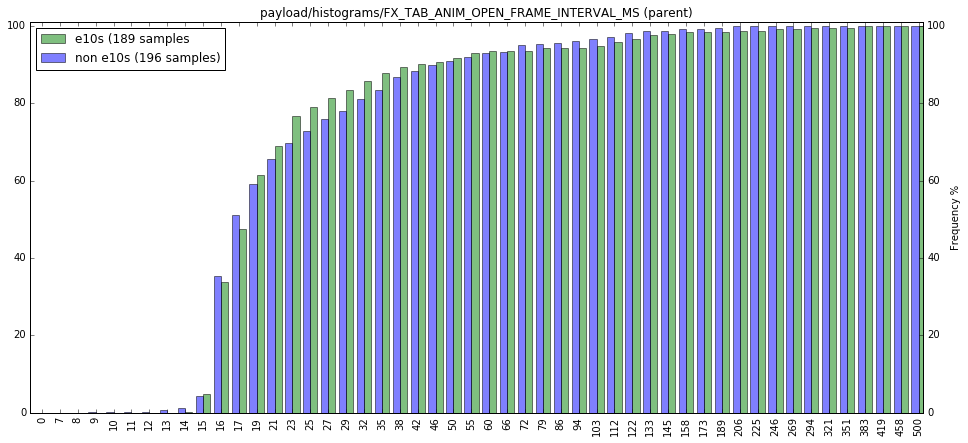

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS (parent) are differing by chance is 0.53.


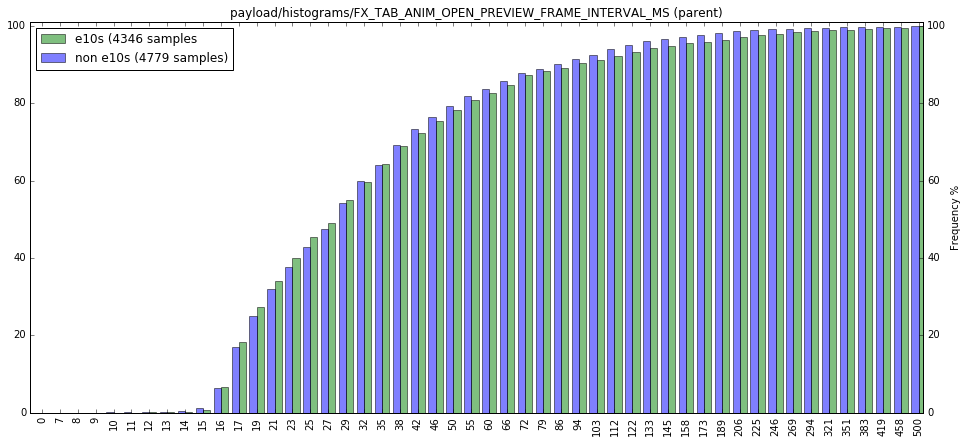

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


In [49]:
compare_histograms(subset,
                   "payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS")

#### d) Graphics:

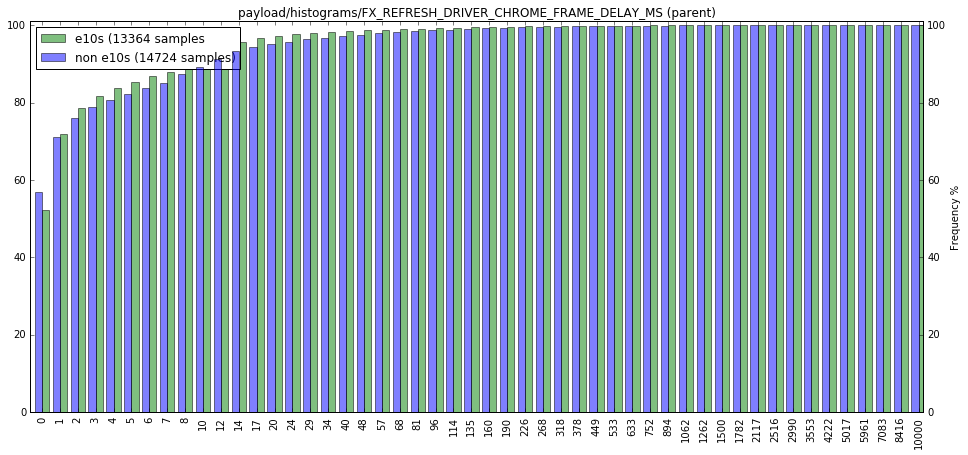

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS (parent) are differing by chance is 0.00.


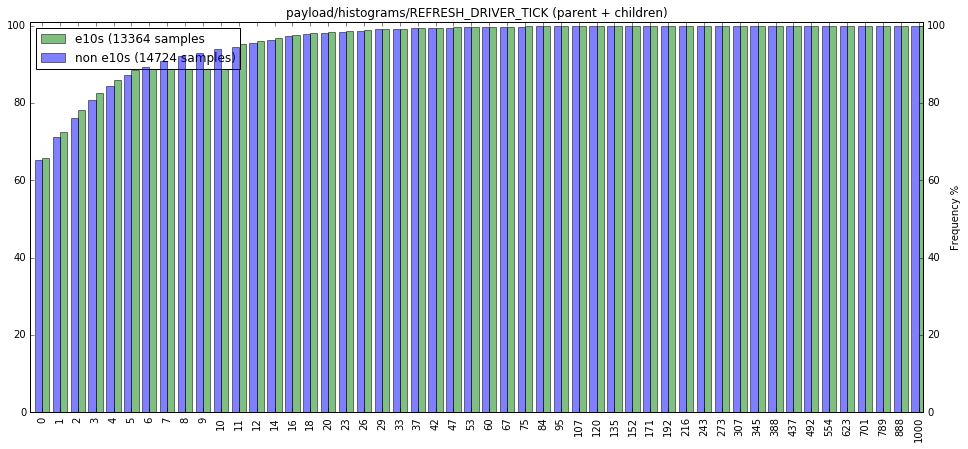

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent + children) are differing by chance is 0.00.


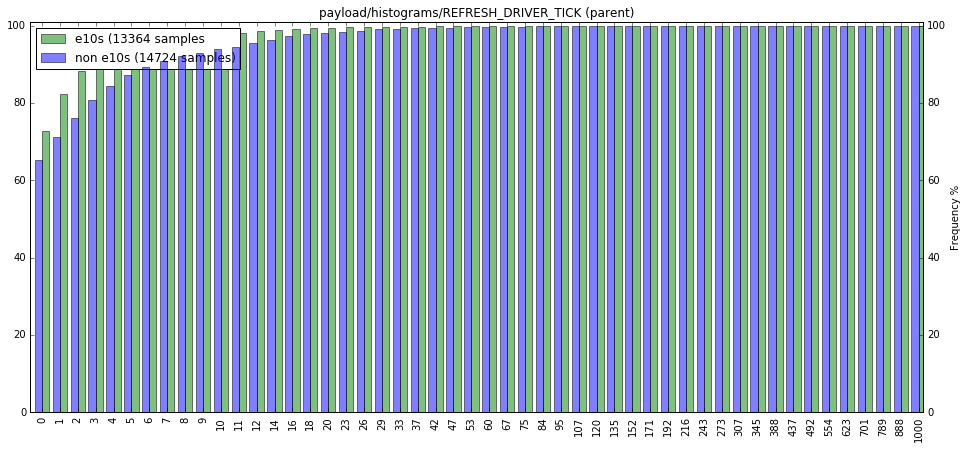

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent) are differing by chance is 0.00.


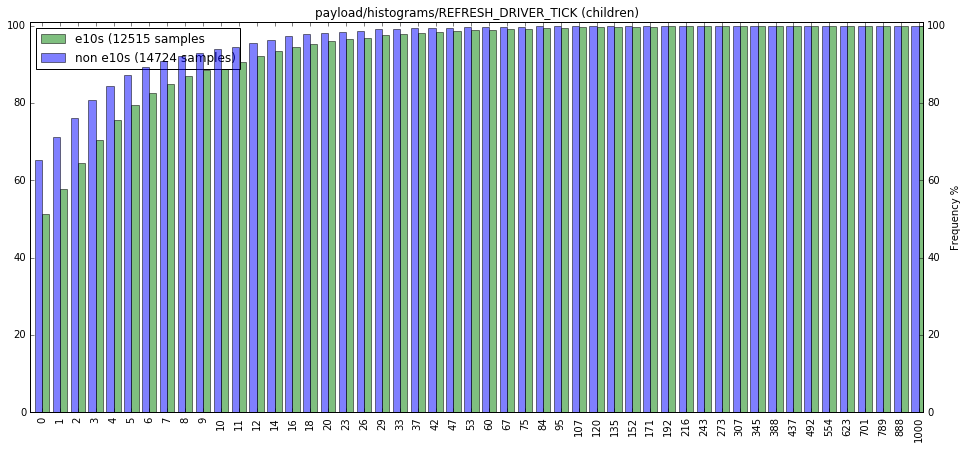

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (children) are differing by chance is 0.00.


In [50]:
compare_histograms(subset, "payload/histograms/REFRESH_DRIVER_TICK",
                           "payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS")

## 2. Responsivness

#### a) Event processing

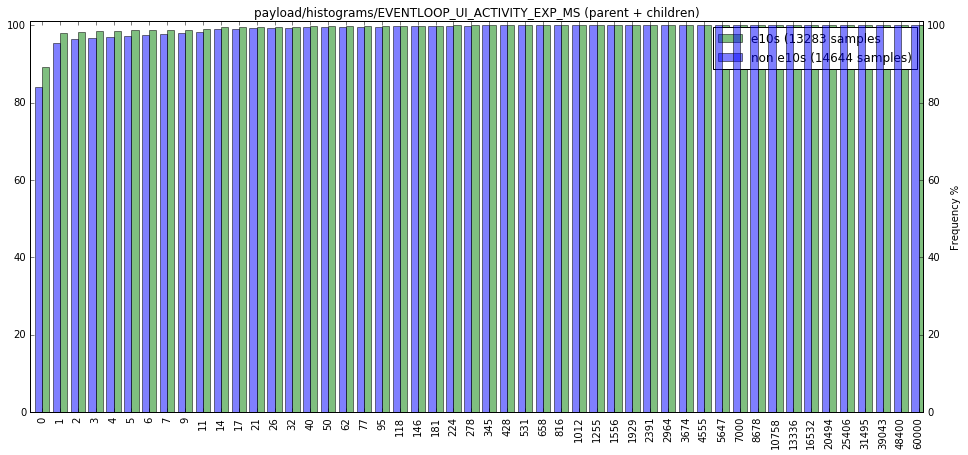

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (parent + children) are differing by chance is 0.00.


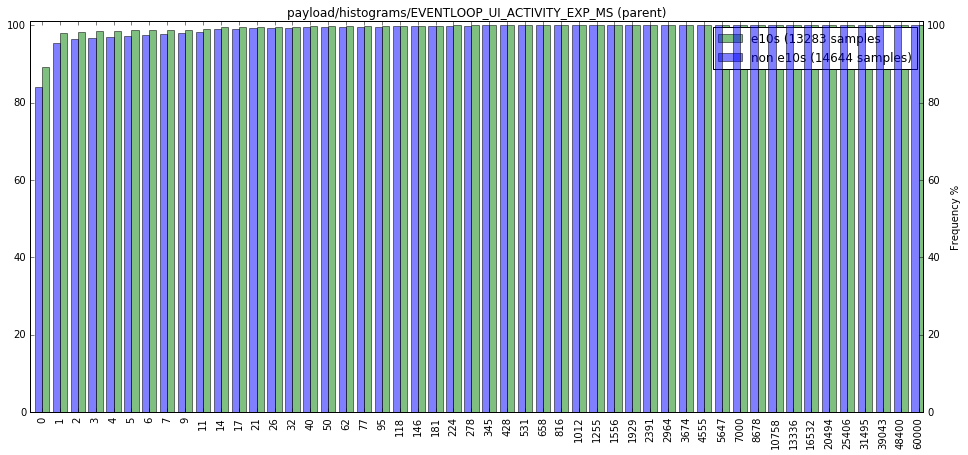

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (parent) are differing by chance is 0.00.


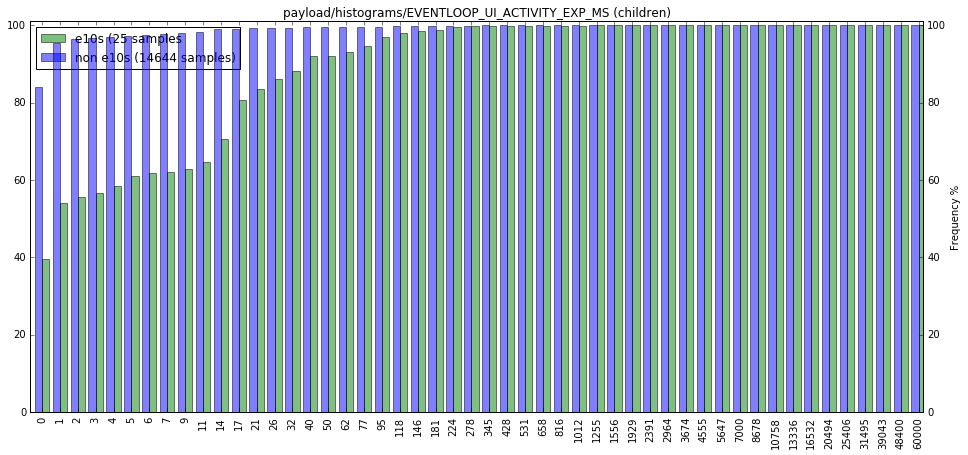

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (children) are differing by chance is 0.00.


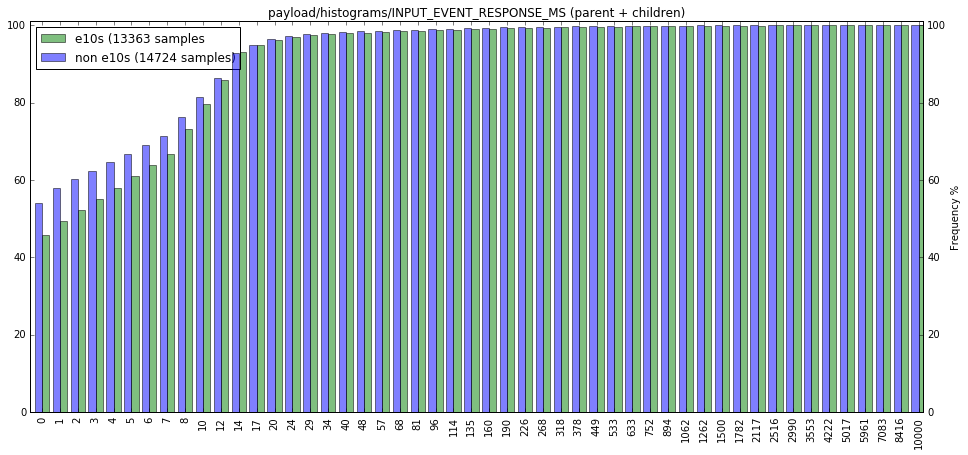

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent + children) are differing by chance is 0.00.


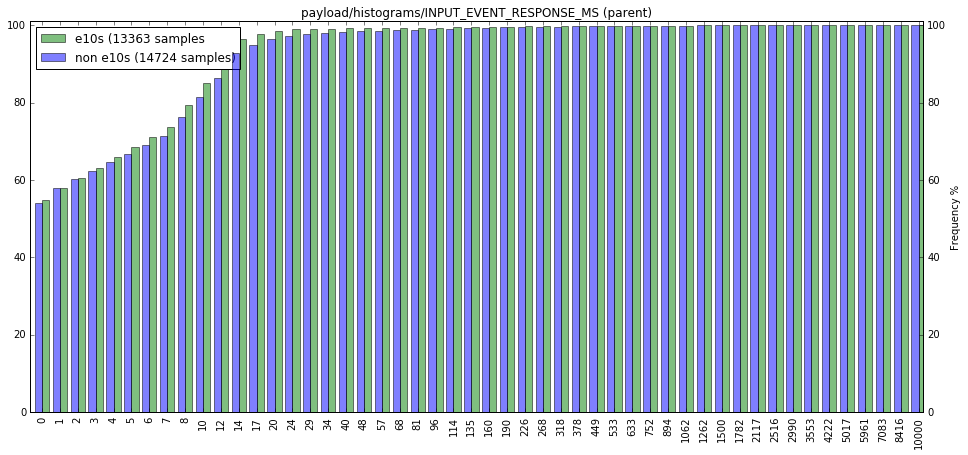

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent) are differing by chance is 0.00.


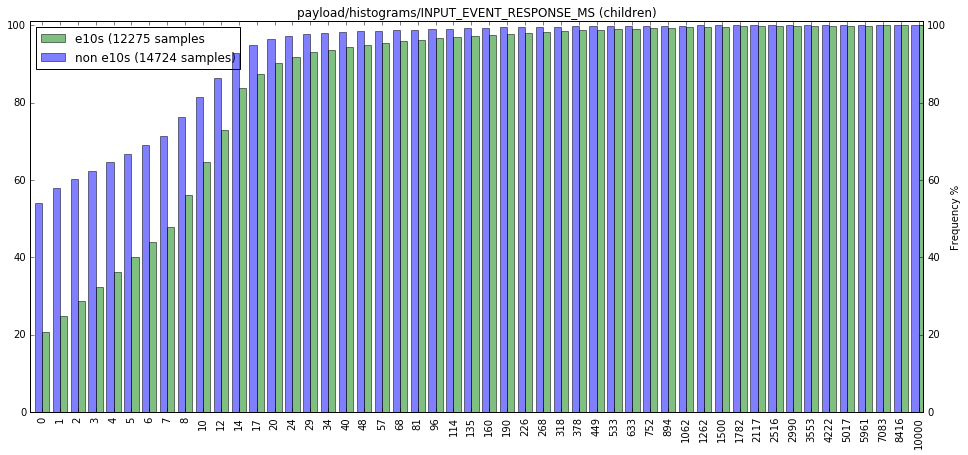

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (children) are differing by chance is 0.00.


In [51]:
compare_histograms(subset, "payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS",
                           "payload/histograms/INPUT_EVENT_RESPONSE_MS")

In [52]:
compare_scalars("hangs over 100ms per minute (parent)",
                eSimple["parent_hangs_per_minute"].dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

Median difference in hangs over 100ms per minute (parent) is -1.60, (0.54, 2.14).
The probability of this effect being purely by chance is 0.00.


In [53]:
compare_scalars("hangs over 100ms per minute (parent + child)",
                (eSimple["child_hangs_per_minute"] + eSimple["parent_hangs_per_minute"]).dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

Median difference in hangs over 100ms per minute (parent + child) is 0.09, (2.23, 2.14).
The probability of this effect being purely by chance is 0.13.


#### b) Plugins

In [54]:
compare_count_histograms(subset, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin")

Median difference in payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin per hour is -0.06, (0.48, 0.54).
The probability of this effect being purely by chance is 0.65.


#### c) Page load

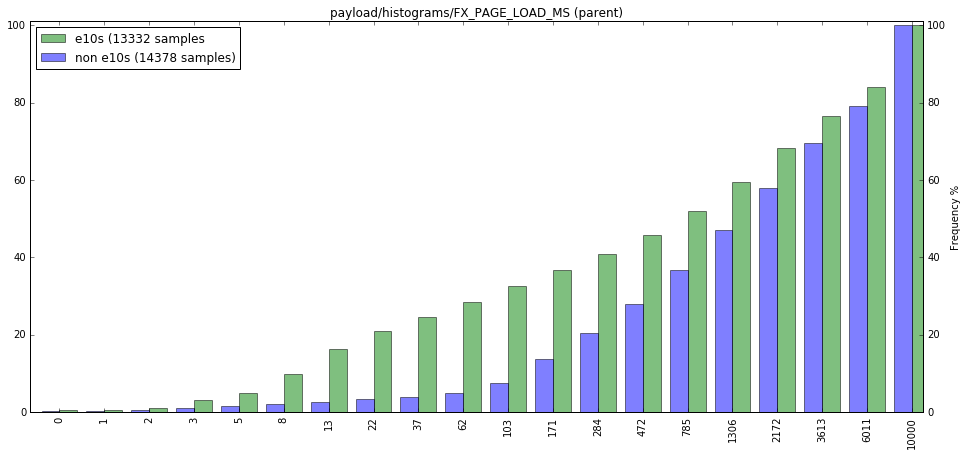

The probability that the distributions for payload/histograms/FX_PAGE_LOAD_MS (parent) are differing by chance is 0.00.


In [55]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

#### d) Slow scripts

In [56]:
compare_count_histograms(big_subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_NOTICE_COUNT per hour is 0.21, (0.67, 0.46).
The probability of this effect being purely by chance is 0.00.


In [57]:
compare_count_histograms(big_subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_PAGE_COUNT per hour is 0.11, (0.47, 0.36).
The probability of this effect being purely by chance is 0.00.


#### e) Window open time

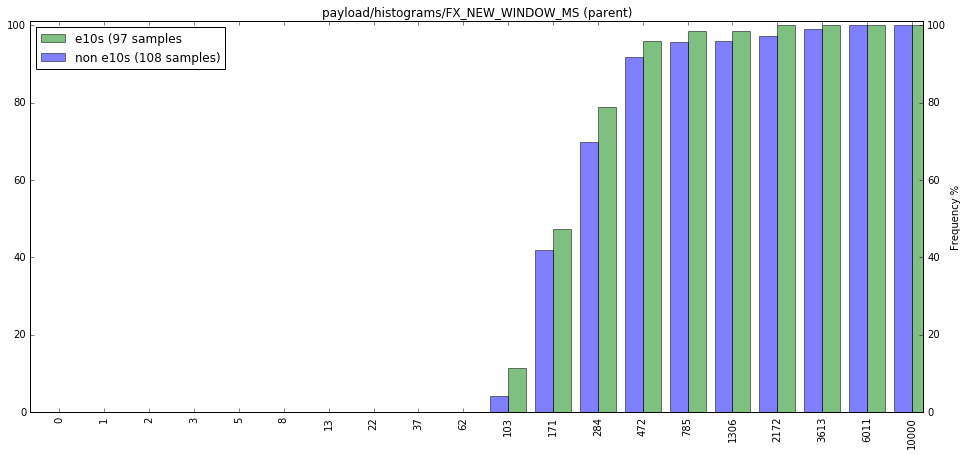

The probability that the distributions for payload/histograms/FX_NEW_WINDOW_MS (parent) are differing by chance is 0.33.


In [58]:
compare_histograms(subset, "payload/histograms/FX_NEW_WINDOW_MS")

#### f) Garbage collection

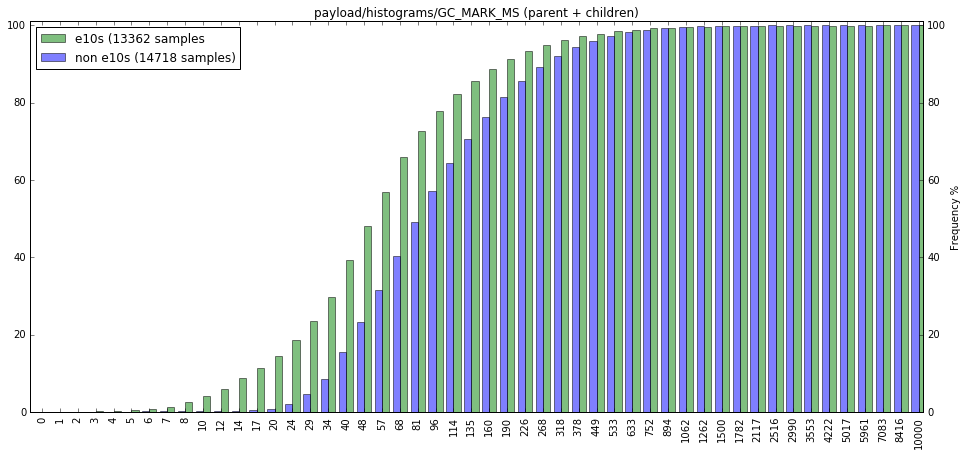

The probability that the distributions for payload/histograms/GC_MARK_MS (parent + children) are differing by chance is 0.00.


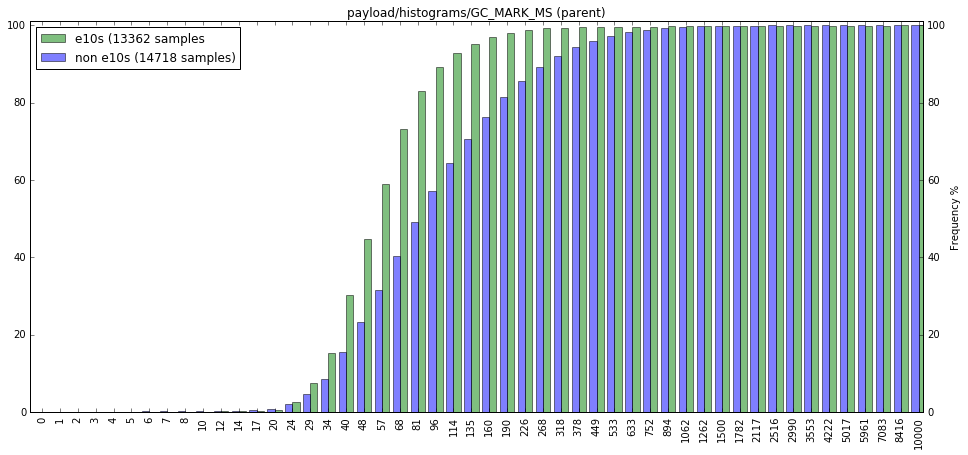

The probability that the distributions for payload/histograms/GC_MARK_MS (parent) are differing by chance is 0.00.


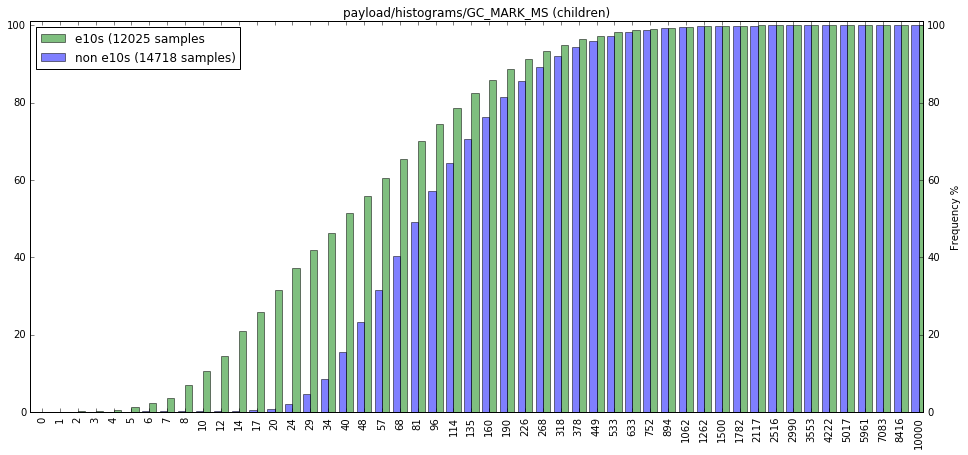

The probability that the distributions for payload/histograms/GC_MARK_MS (children) are differing by chance is 0.00.


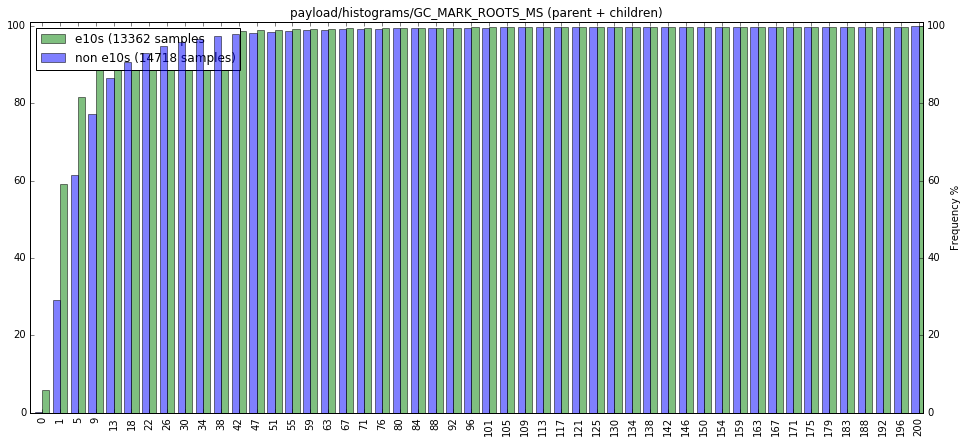

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent + children) are differing by chance is 0.00.


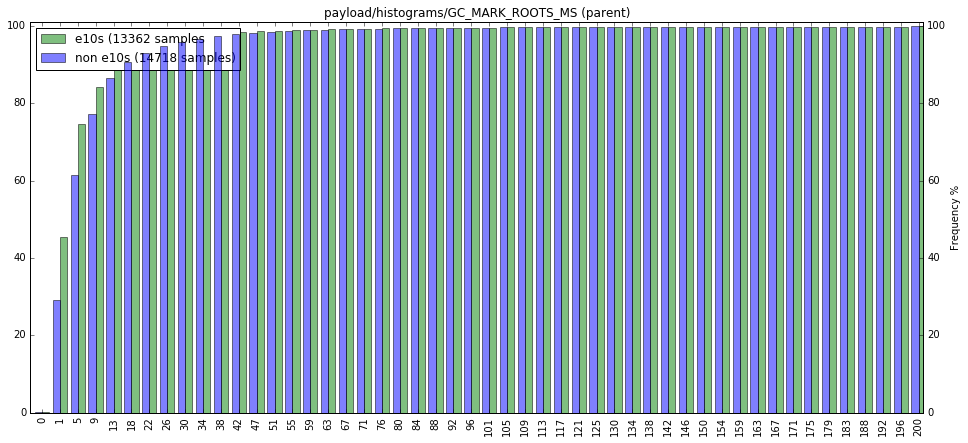

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent) are differing by chance is 0.00.


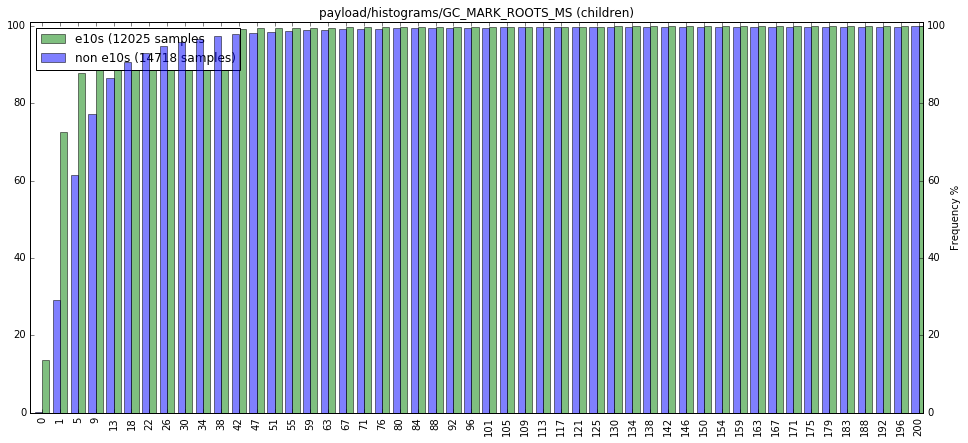

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (children) are differing by chance is 0.00.


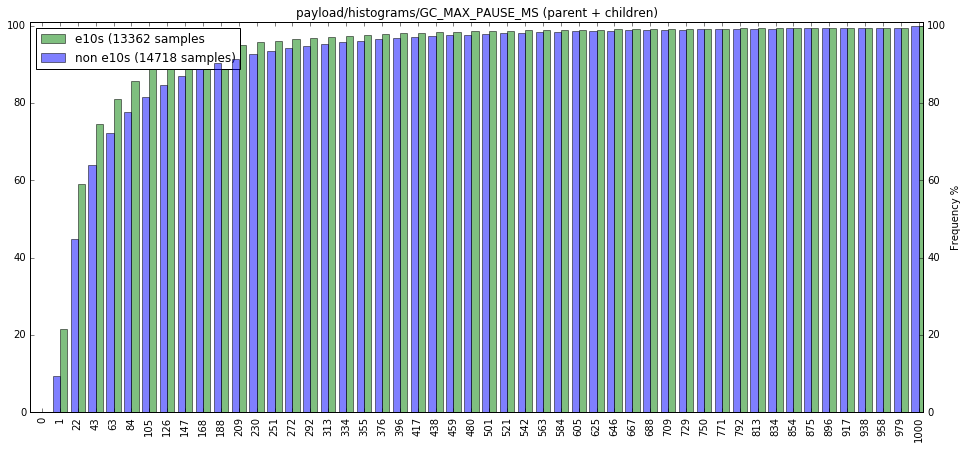

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


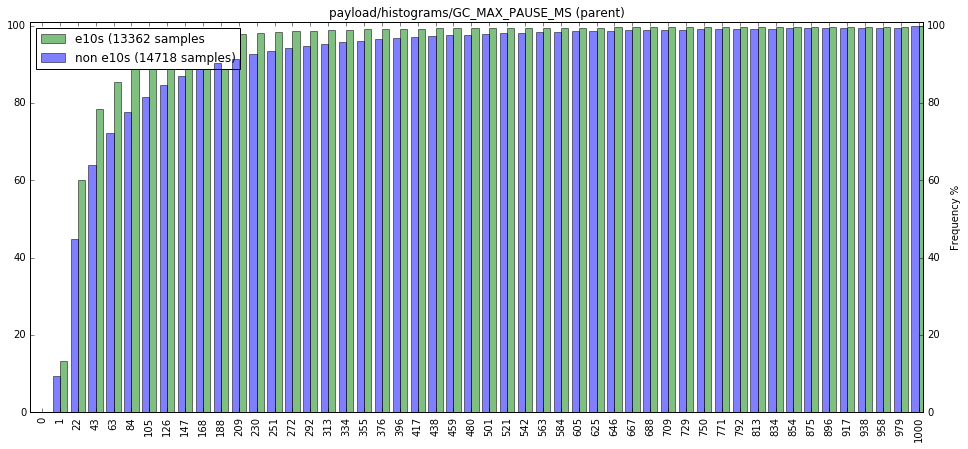

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


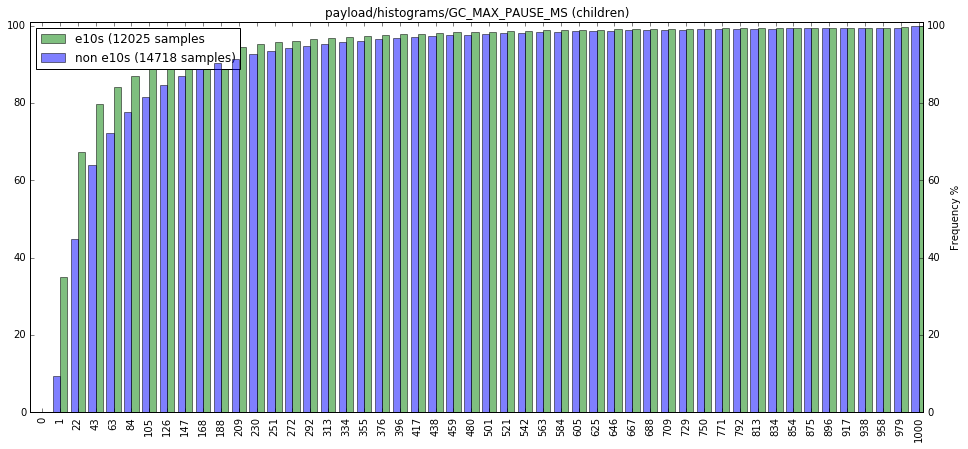

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (children) are differing by chance is 0.00.


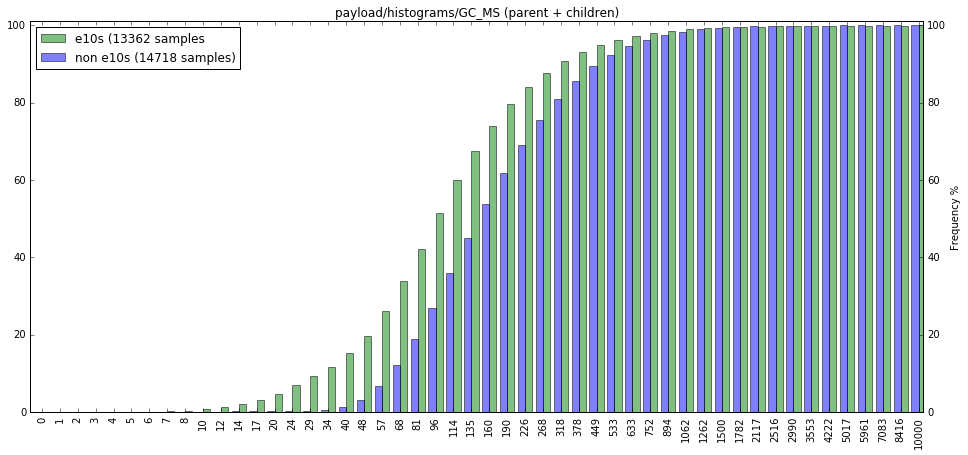

The probability that the distributions for payload/histograms/GC_MS (parent + children) are differing by chance is 0.00.


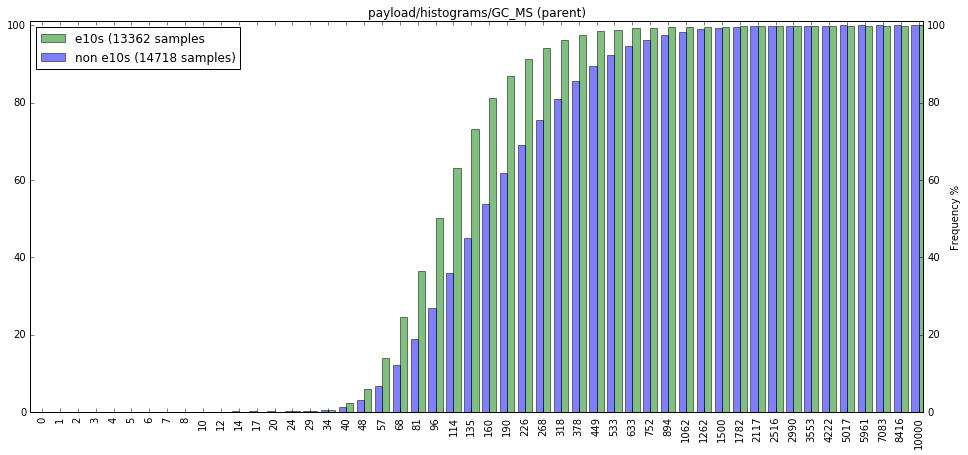

The probability that the distributions for payload/histograms/GC_MS (parent) are differing by chance is 0.00.


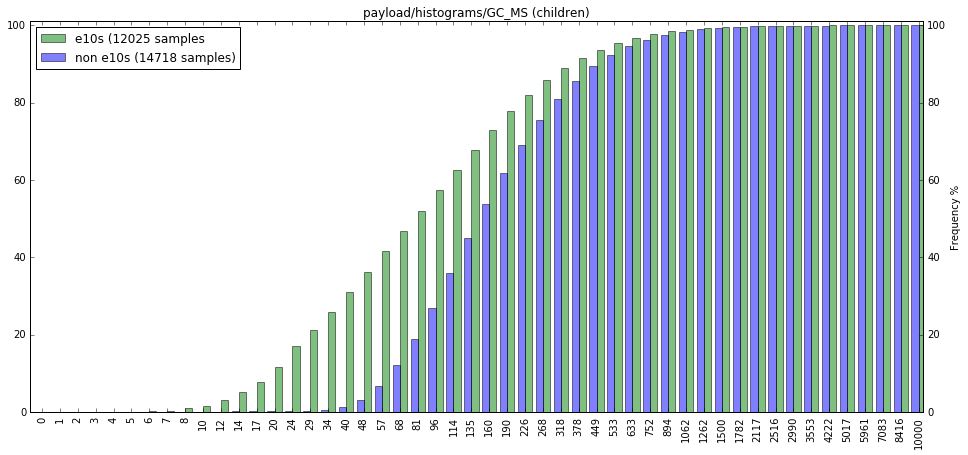

The probability that the distributions for payload/histograms/GC_MS (children) are differing by chance is 0.00.


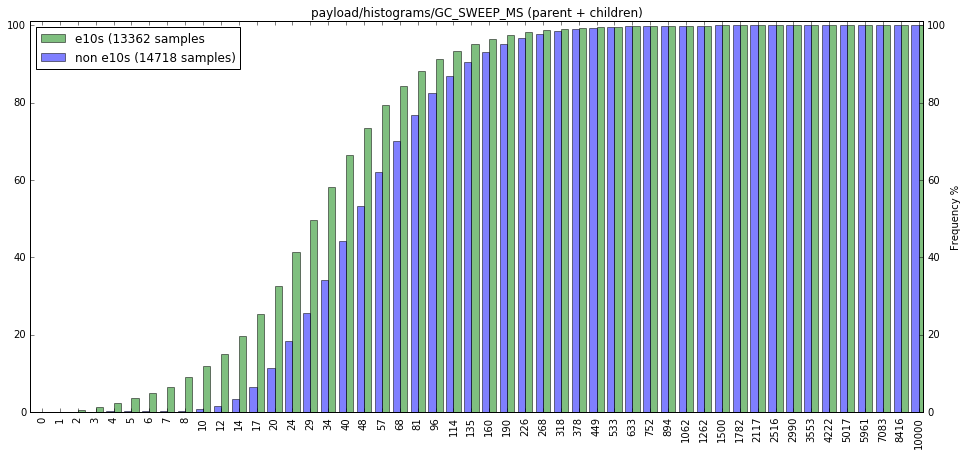

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent + children) are differing by chance is 0.00.


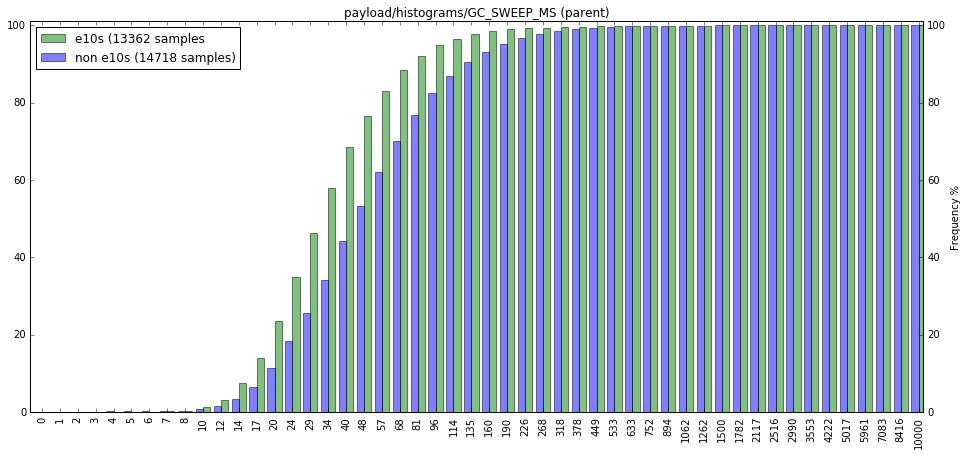

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent) are differing by chance is 0.00.


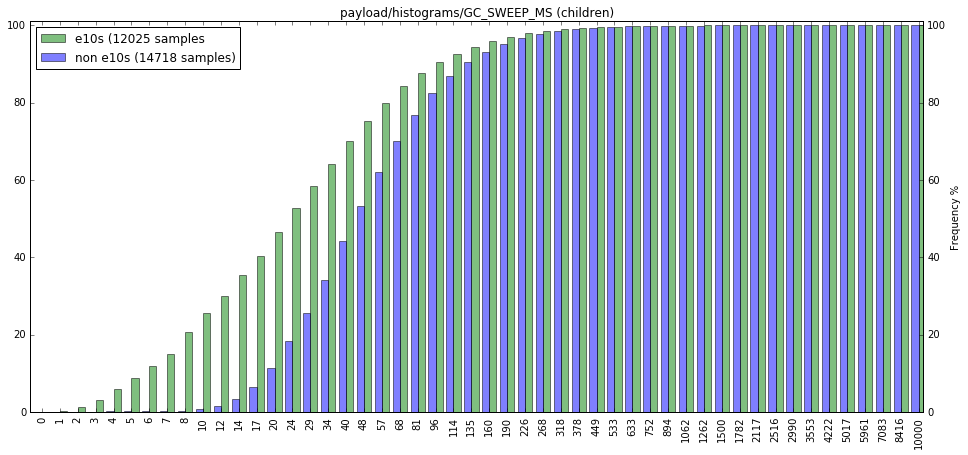

The probability that the distributions for payload/histograms/GC_SWEEP_MS (children) are differing by chance is 0.00.


In [59]:
compare_histograms(subset, 
                   "payload/histograms/GC_MS", 
                   "payload/histograms/GC_MAX_PAUSE_MS", 
                   "payload/histograms/GC_MARK_MS", 
                   "payload/histograms/GC_SWEEP_MS", 
                   "payload/histograms/GC_MARK_ROOTS_MS")

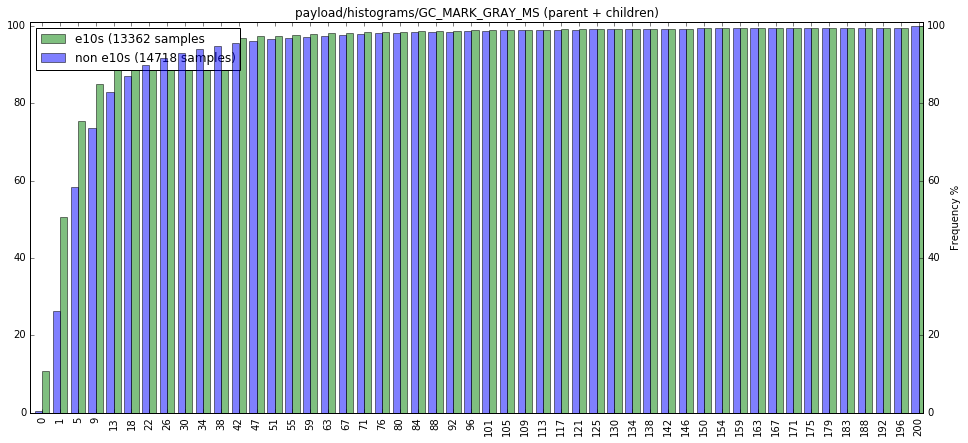

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent + children) are differing by chance is 0.00.


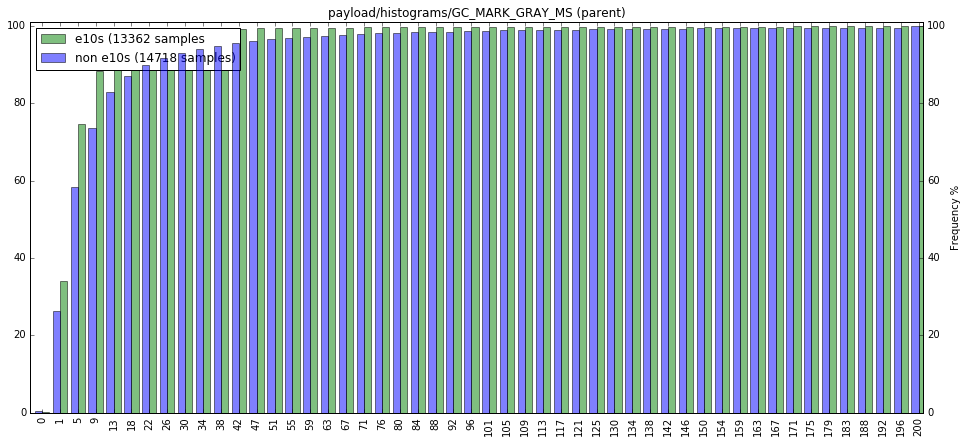

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent) are differing by chance is 0.00.


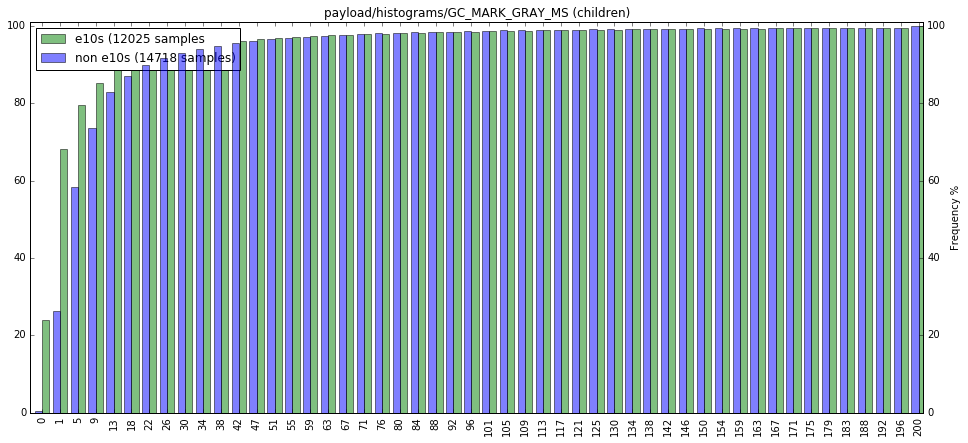

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (children) are differing by chance is 0.00.


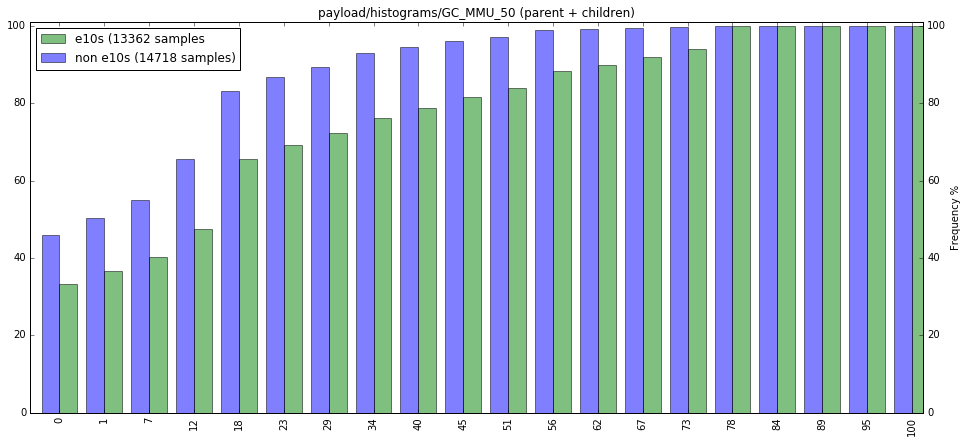

The probability that the distributions for payload/histograms/GC_MMU_50 (parent + children) are differing by chance is 0.00.


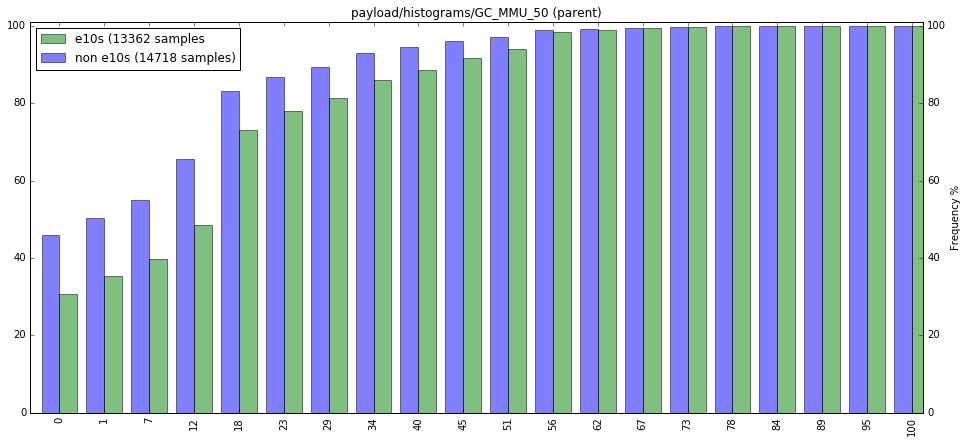

The probability that the distributions for payload/histograms/GC_MMU_50 (parent) are differing by chance is 0.00.


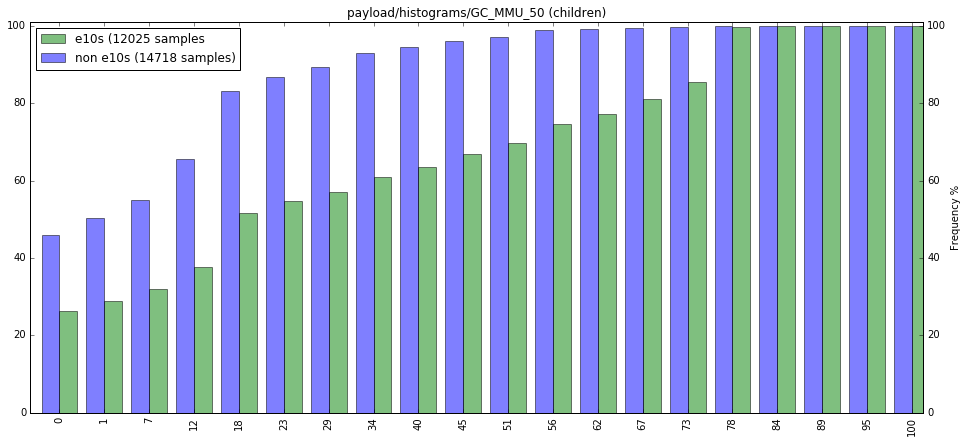

The probability that the distributions for payload/histograms/GC_MMU_50 (children) are differing by chance is 0.00.


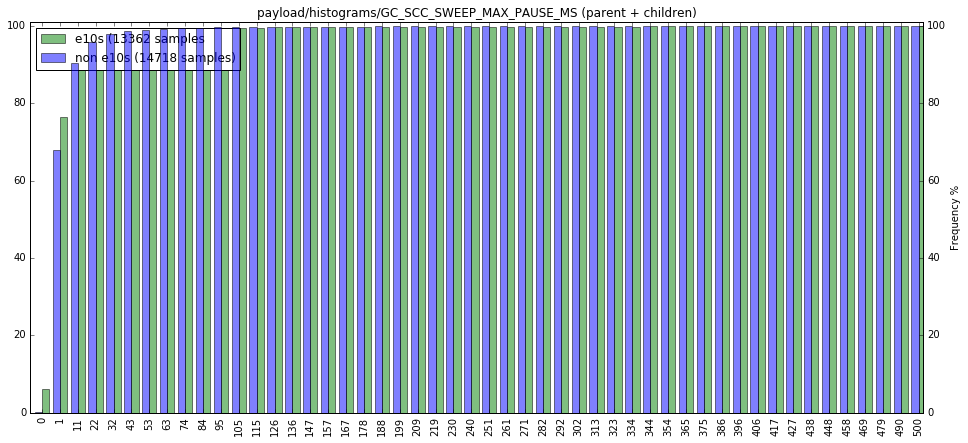

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


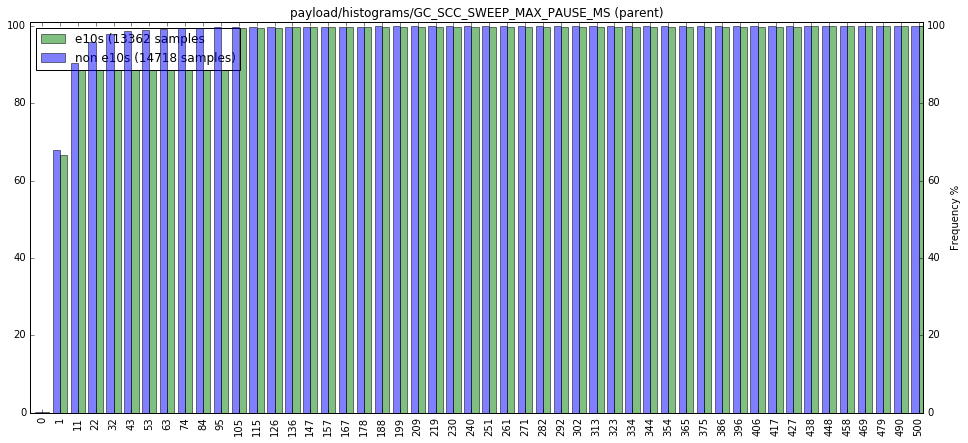

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


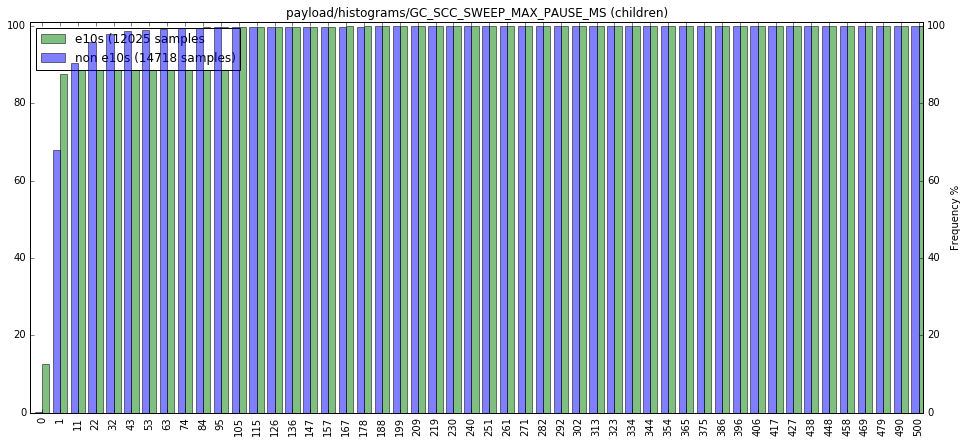

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (children) are differing by chance is 0.00.


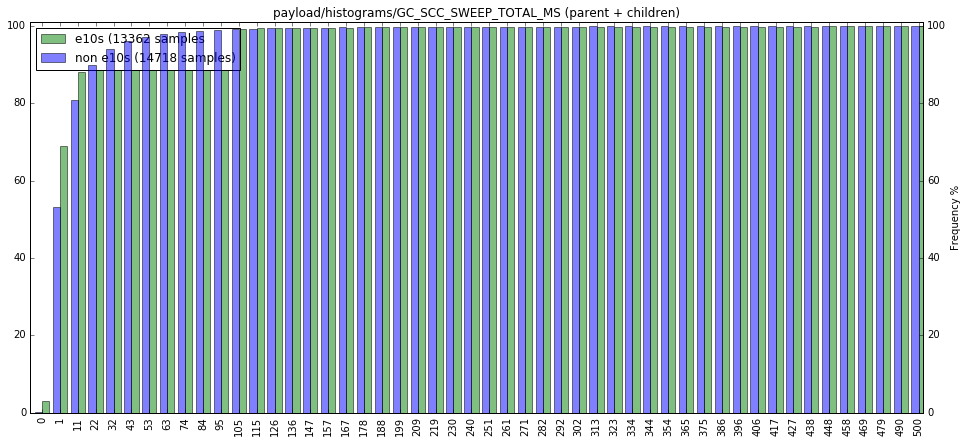

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent + children) are differing by chance is 0.00.


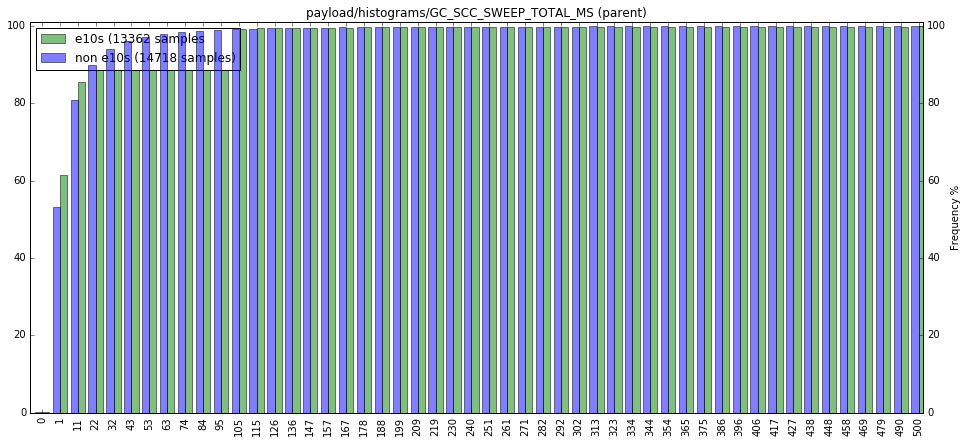

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent) are differing by chance is 0.00.


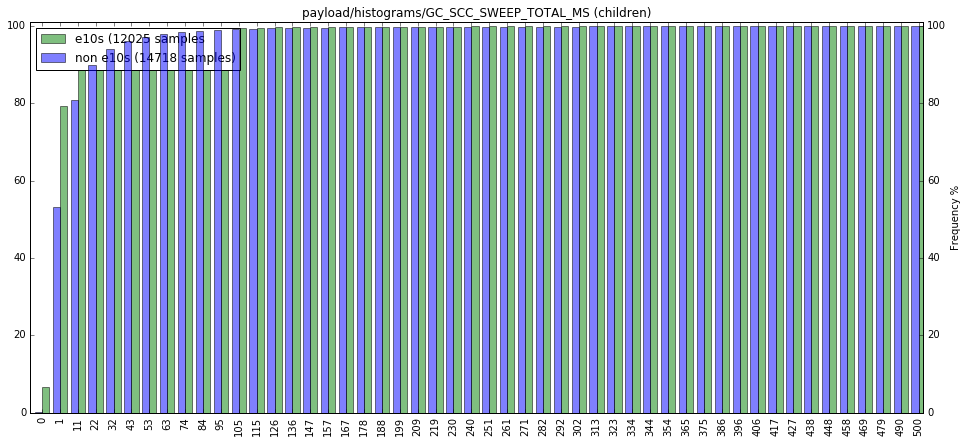

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (children) are differing by chance is 0.00.


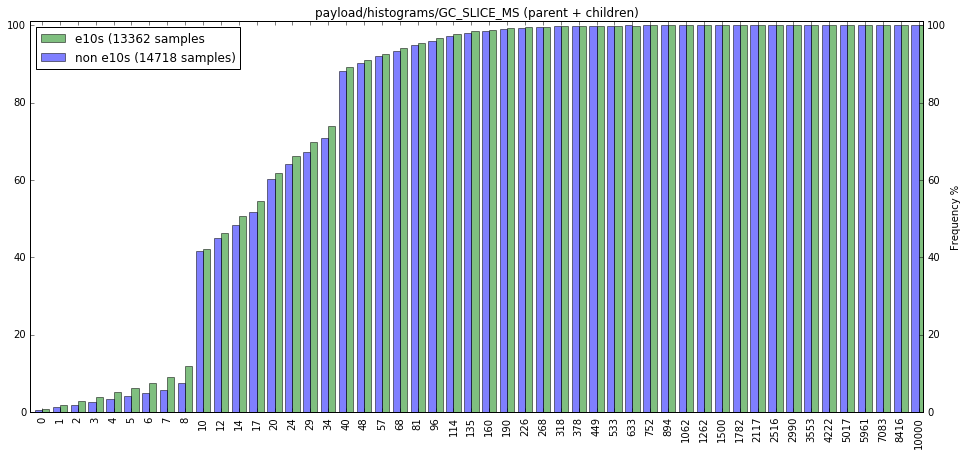

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent + children) are differing by chance is 0.00.


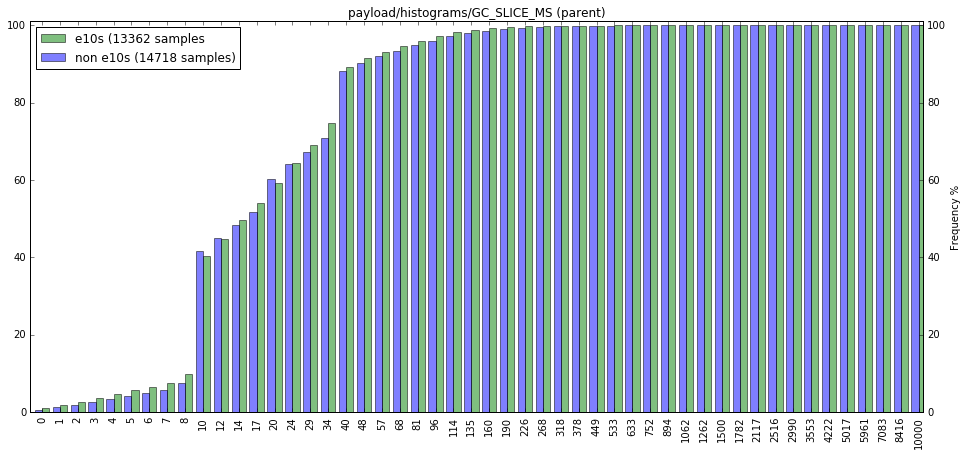

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent) are differing by chance is 0.00.


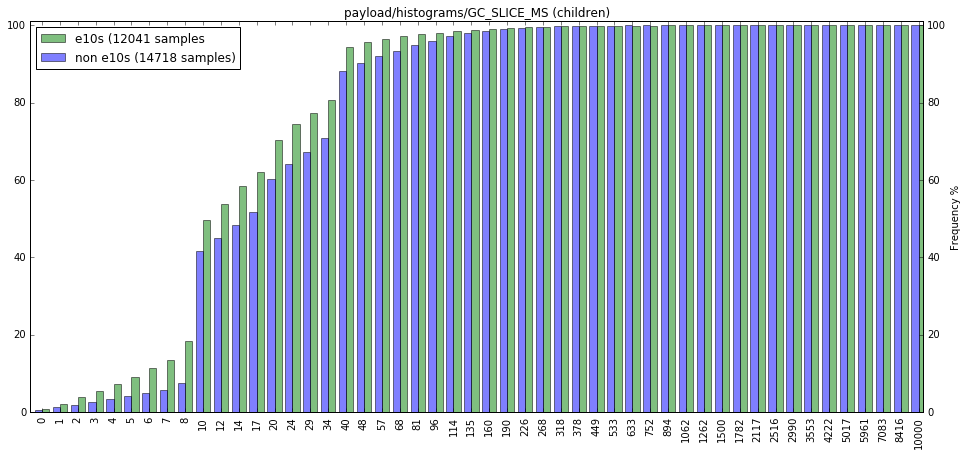

The probability that the distributions for payload/histograms/GC_SLICE_MS (children) are differing by chance is 0.00.


In [60]:
compare_histograms(subset,
                   "payload/histograms/GC_MMU_50",
                   "payload/histograms/GC_MARK_GRAY_MS",
                   "payload/histograms/GC_SLICE_MS",
                   "payload/histograms/GC_SCC_SWEEP_TOTAL_MS",
                   "payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS")

#### g) Cycle Collector

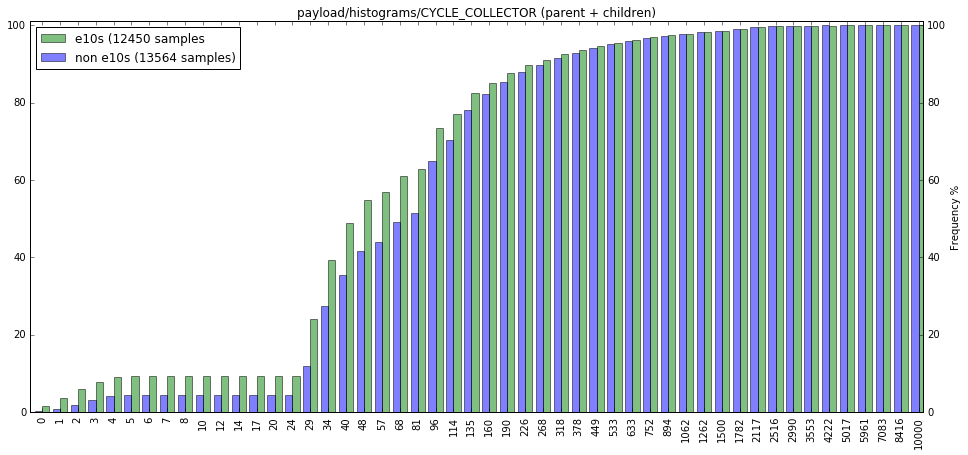

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent + children) are differing by chance is 0.00.


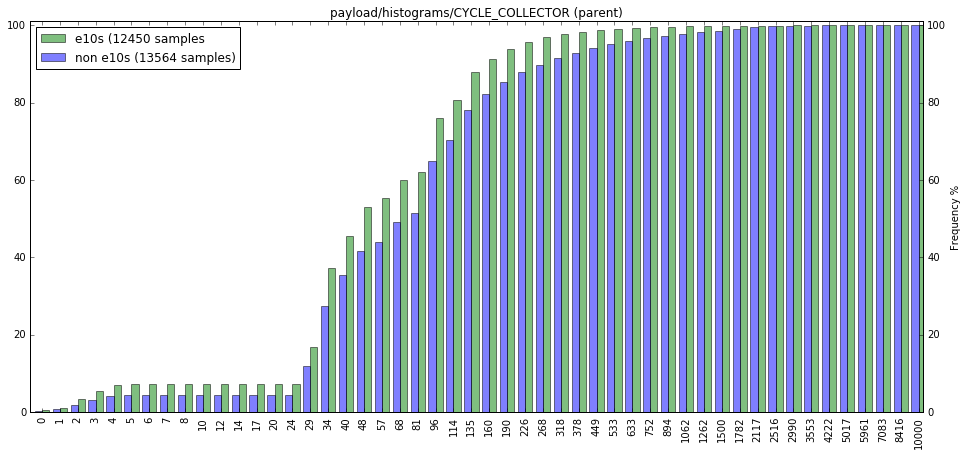

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent) are differing by chance is 0.00.


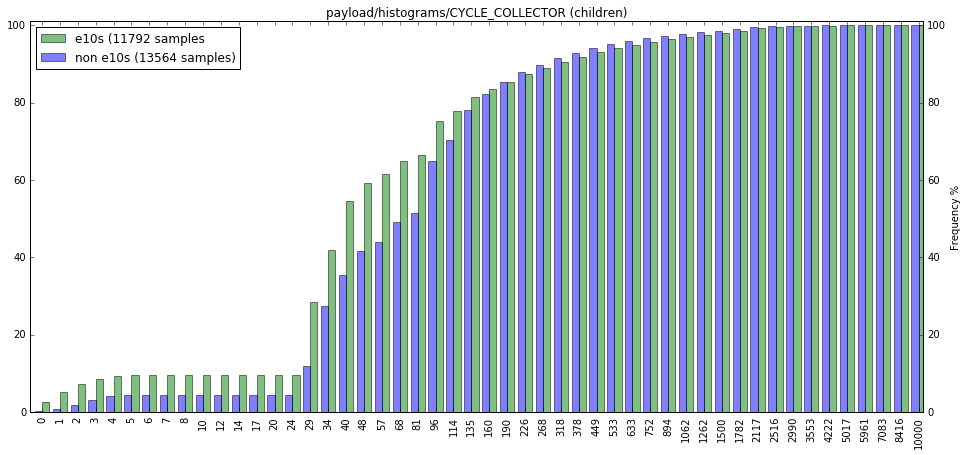

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (children) are differing by chance is 0.00.


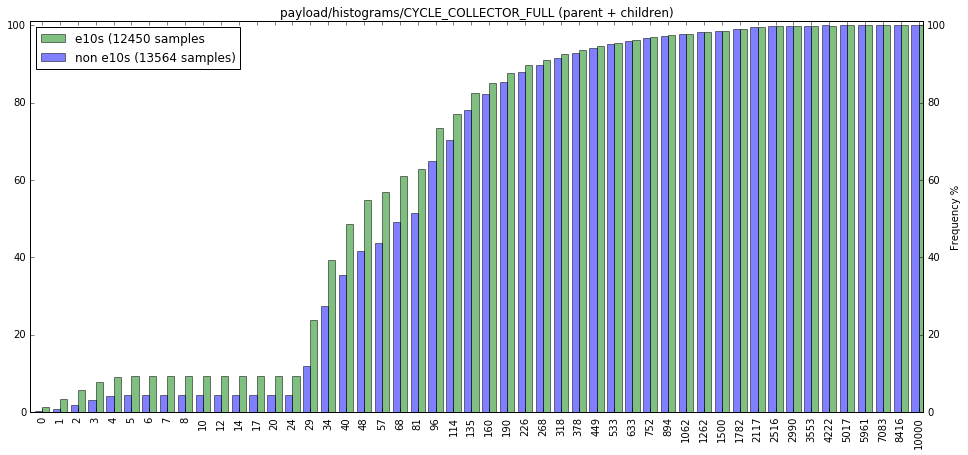

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent + children) are differing by chance is 0.00.


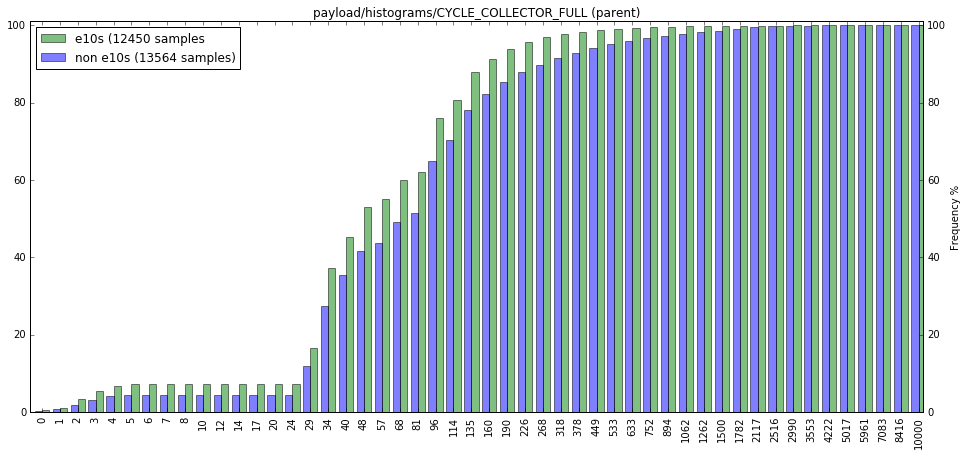

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent) are differing by chance is 0.00.


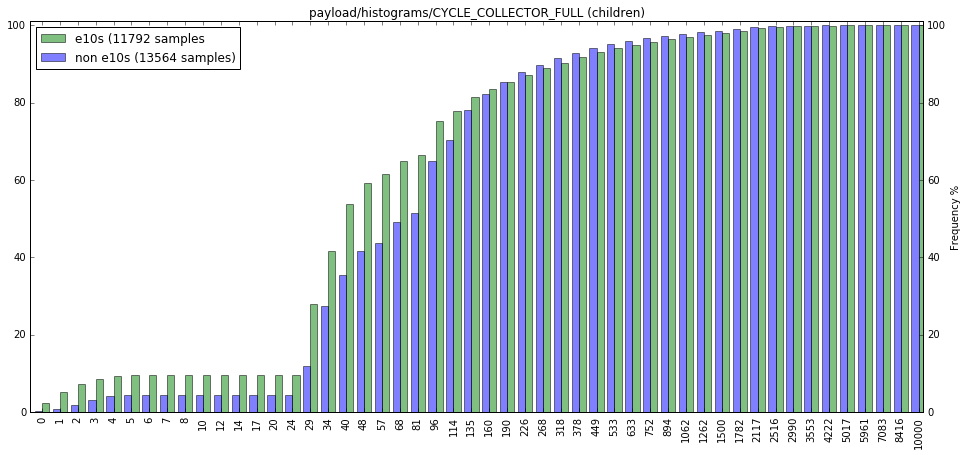

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (children) are differing by chance is 0.00.


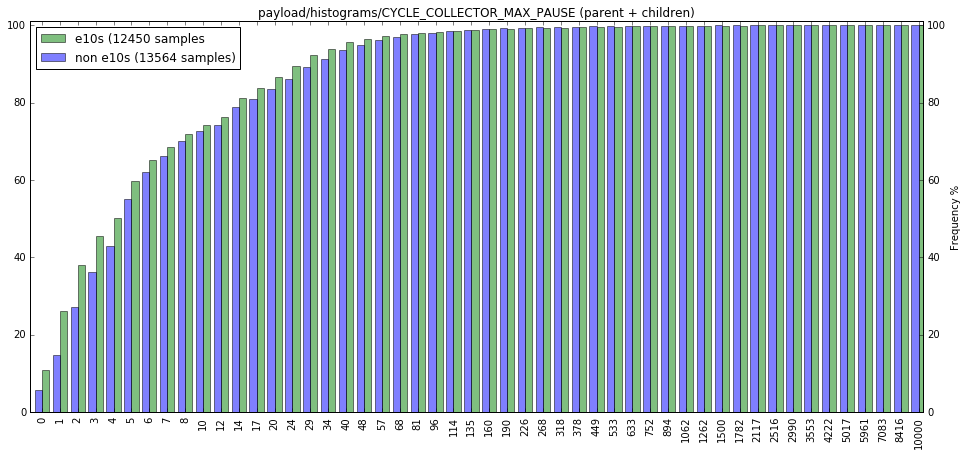

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent + children) are differing by chance is 0.00.


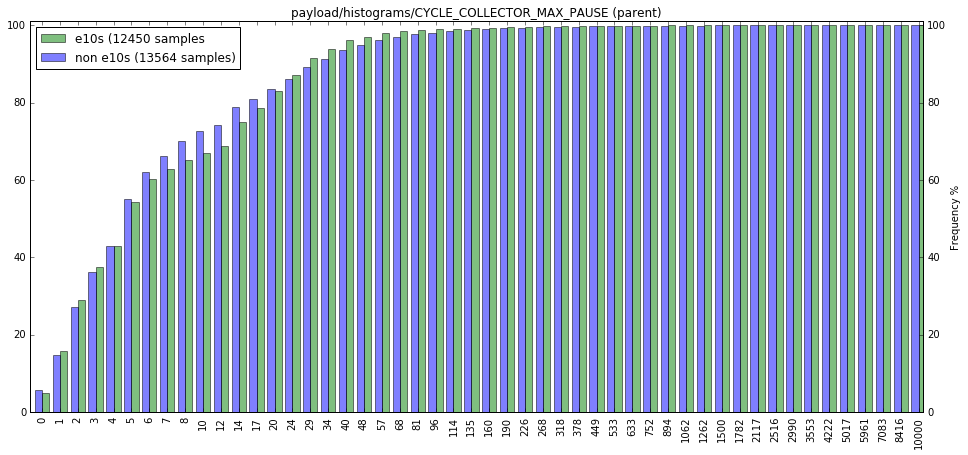

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent) are differing by chance is 0.00.


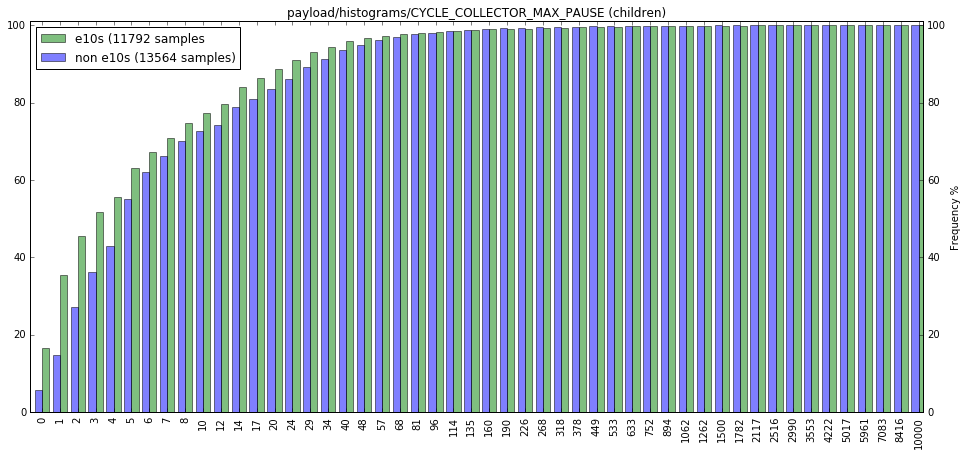

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (children) are differing by chance is 0.00.


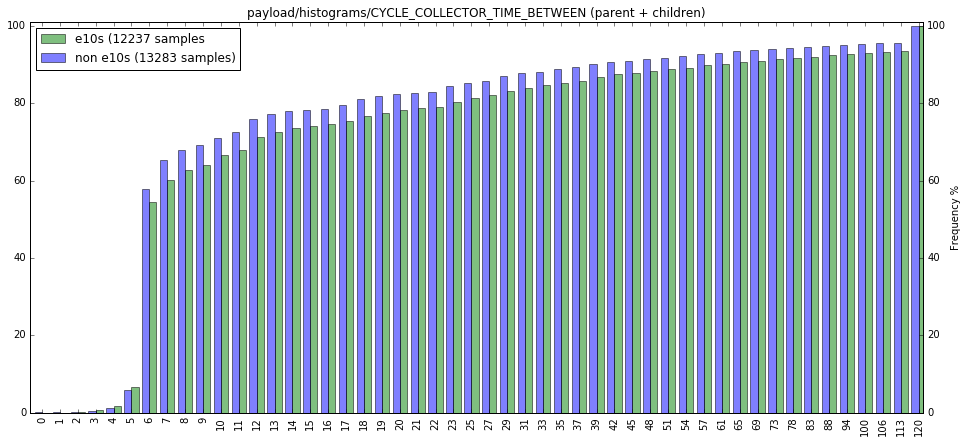

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent + children) are differing by chance is 0.00.


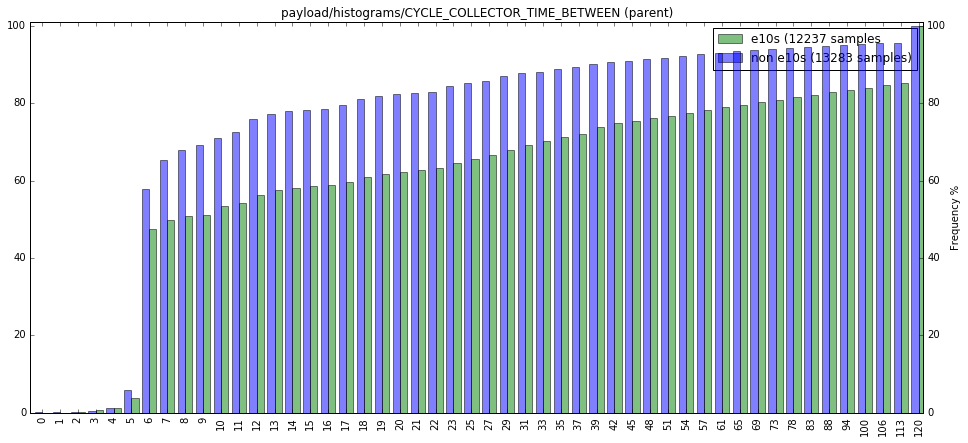

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent) are differing by chance is 0.00.


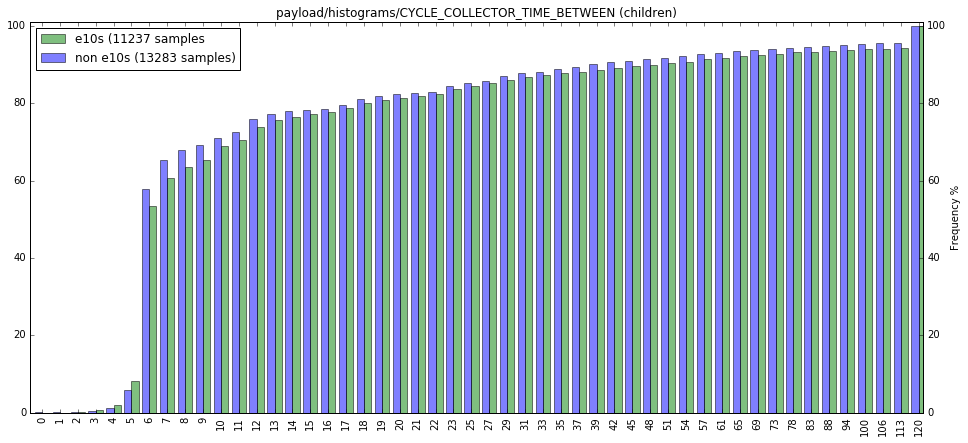

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (children) are differing by chance is 0.00.


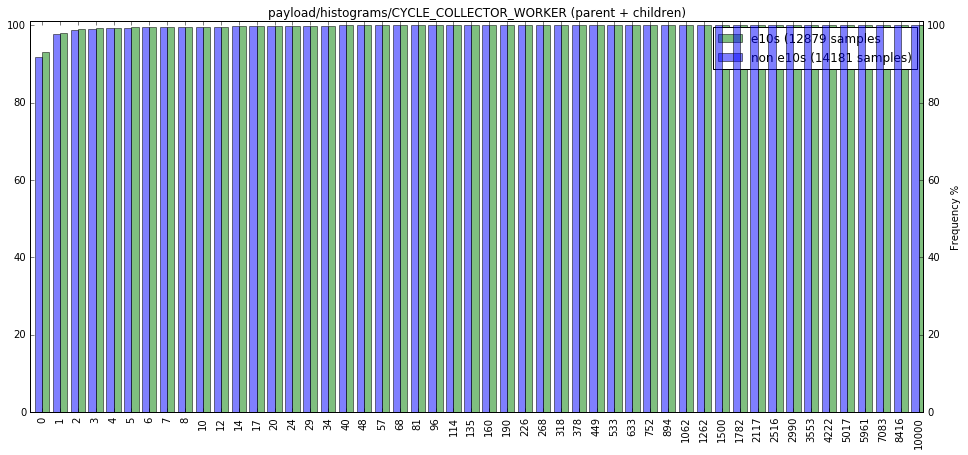

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent + children) are differing by chance is 0.00.


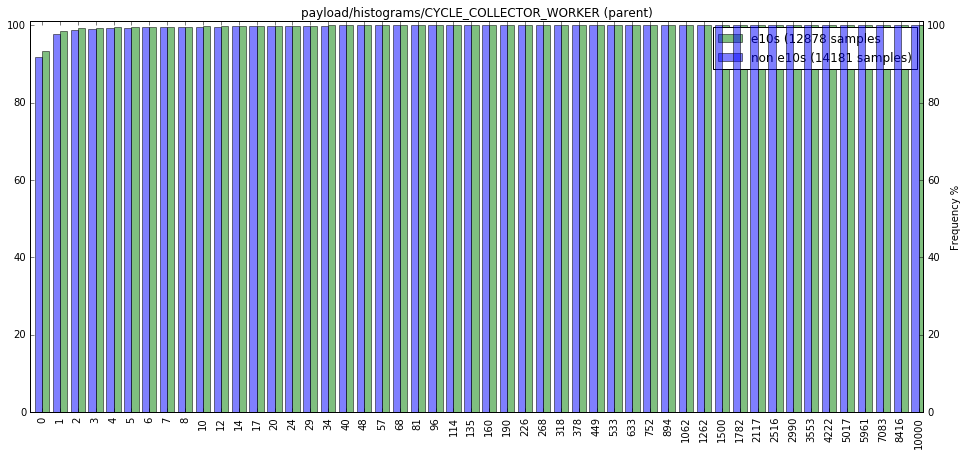

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent) are differing by chance is 0.00.


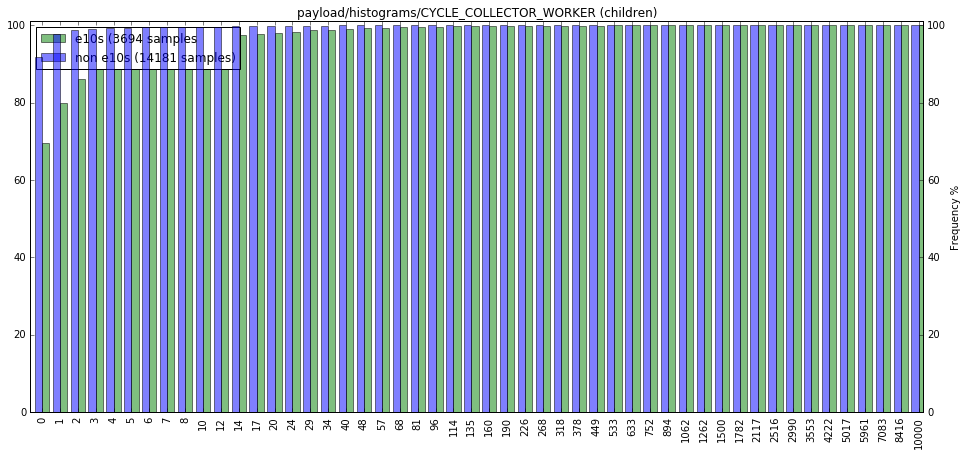

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (children) are differing by chance is 0.00.


In [61]:
compare_histograms(subset,
                   "payload/histograms/CYCLE_COLLECTOR",
                   "payload/histograms/CYCLE_COLLECTOR_WORKER",
                   "payload/histograms/CYCLE_COLLECTOR_FULL",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN")

## 3. Memory

#### a) Usage (bytes)

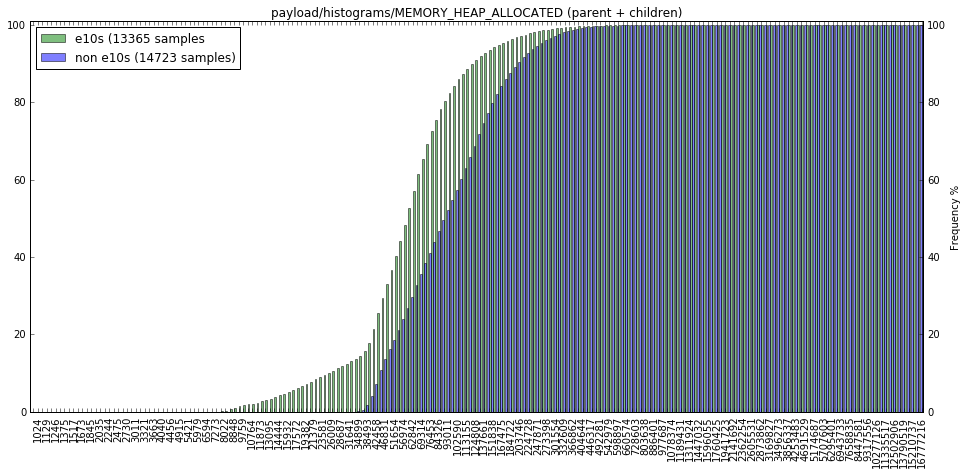

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent + children) are differing by chance is 0.00.


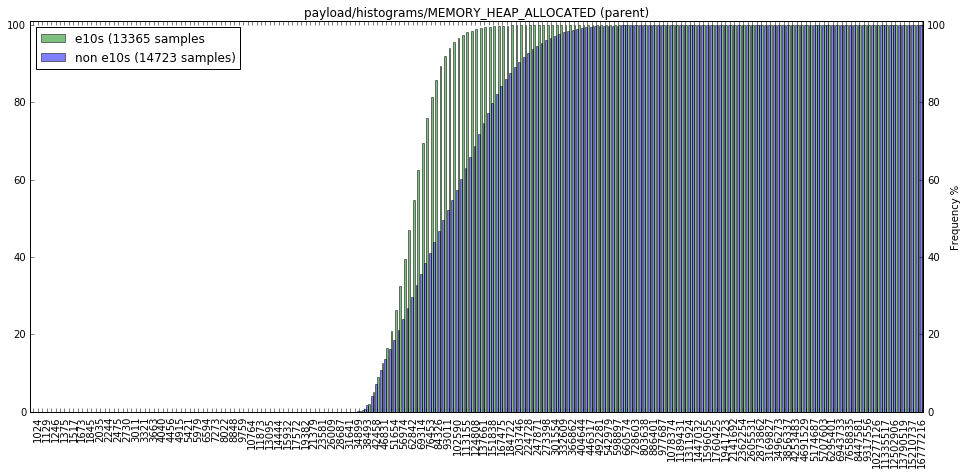

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent) are differing by chance is 0.00.


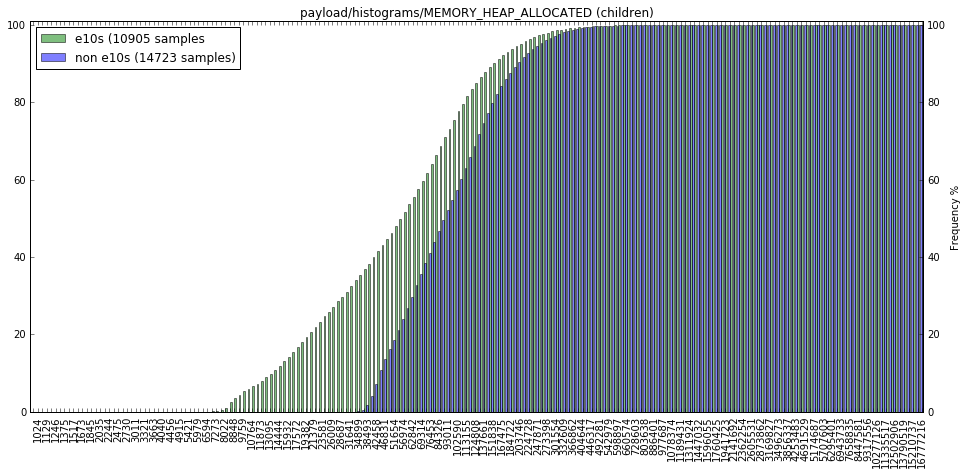

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (children) are differing by chance is 0.00.


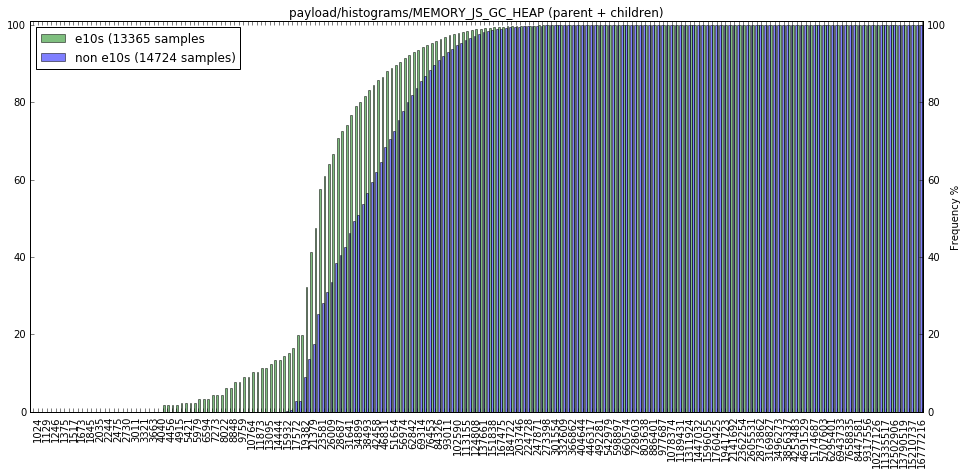

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent + children) are differing by chance is 0.00.


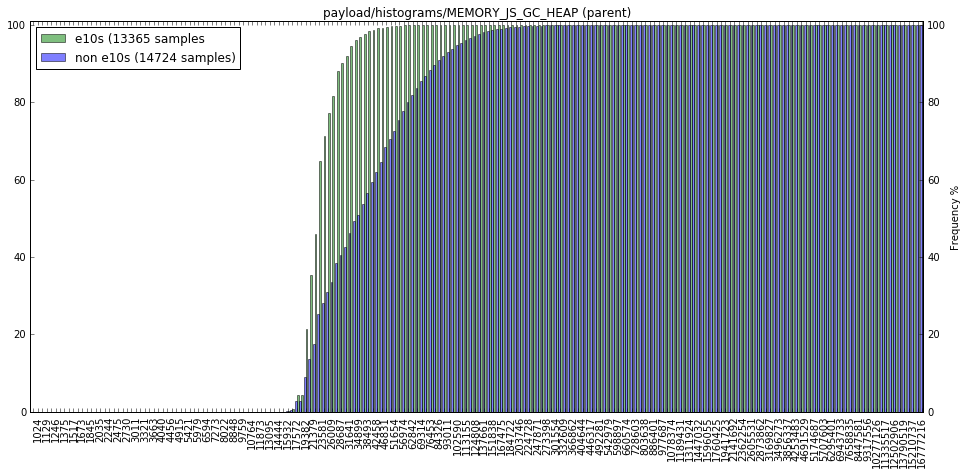

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent) are differing by chance is 0.00.


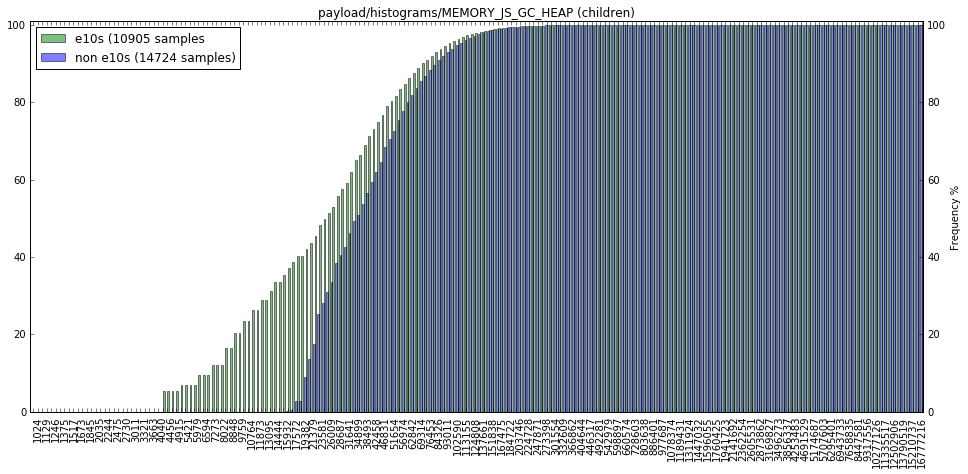

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (children) are differing by chance is 0.00.


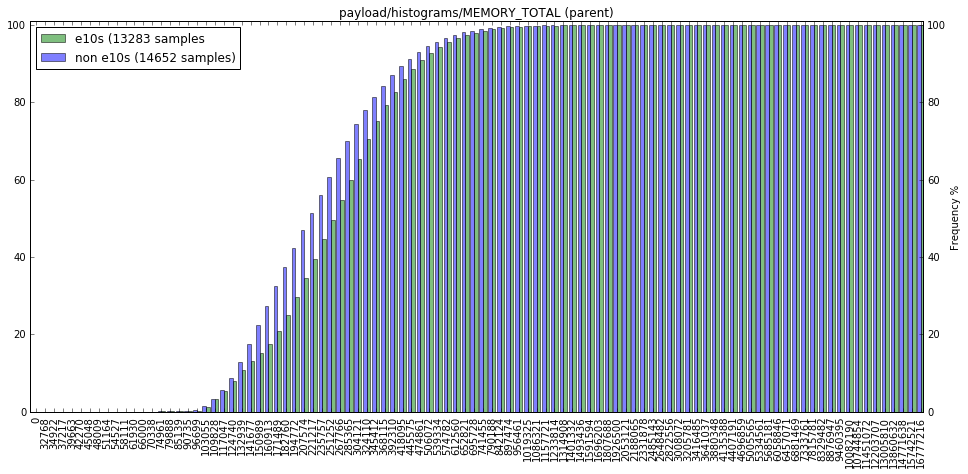

The probability that the distributions for payload/histograms/MEMORY_TOTAL (parent) are differing by chance is 0.00.


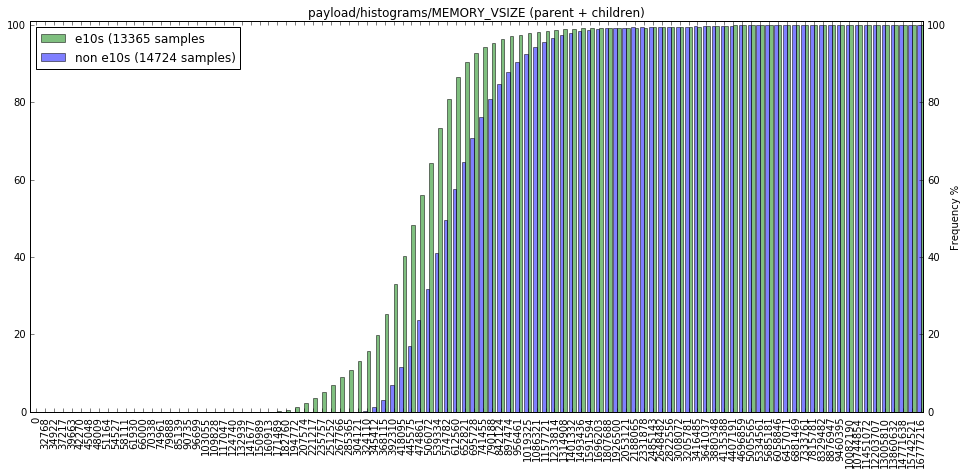

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent + children) are differing by chance is 0.00.


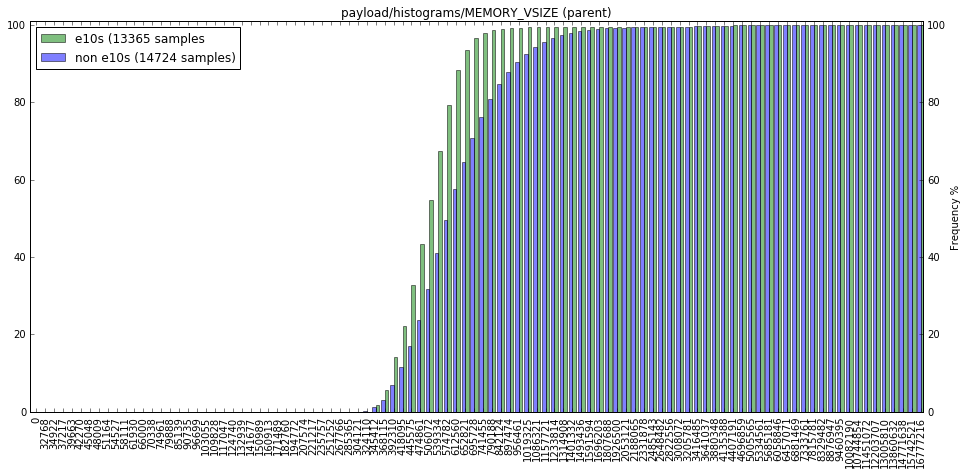

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent) are differing by chance is 0.00.


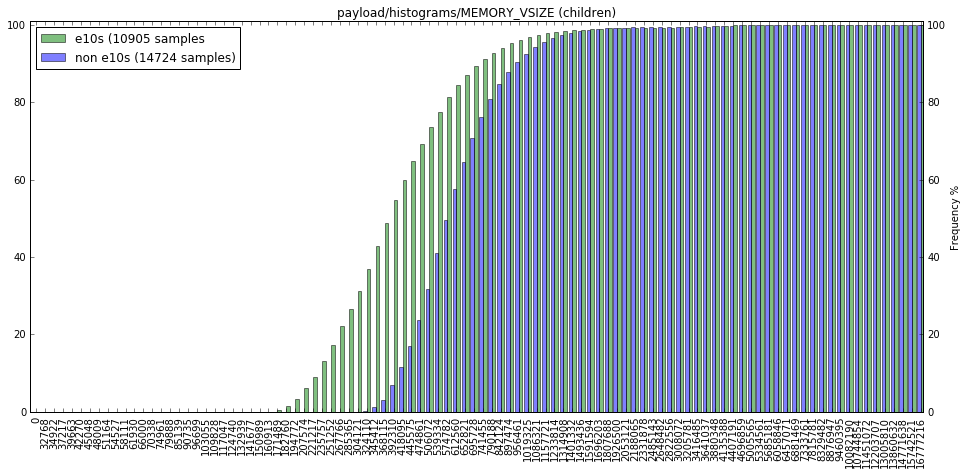

The probability that the distributions for payload/histograms/MEMORY_VSIZE (children) are differing by chance is 0.00.


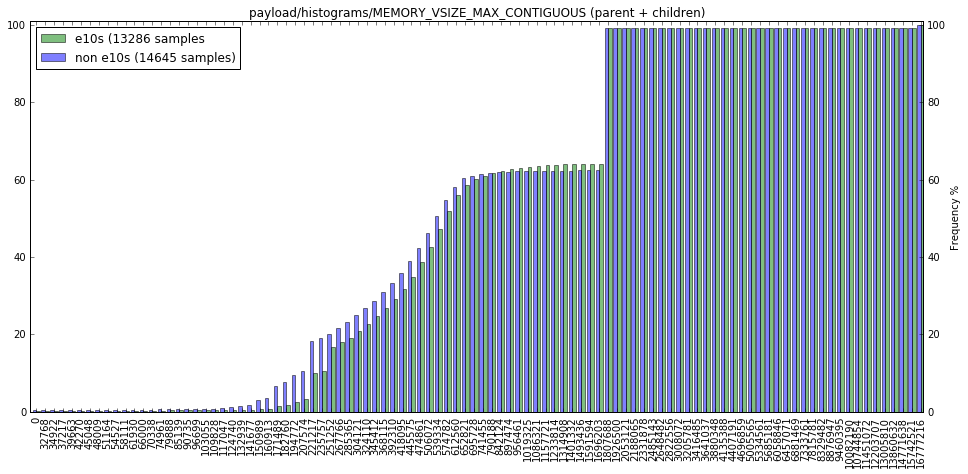

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent + children) are differing by chance is 0.00.


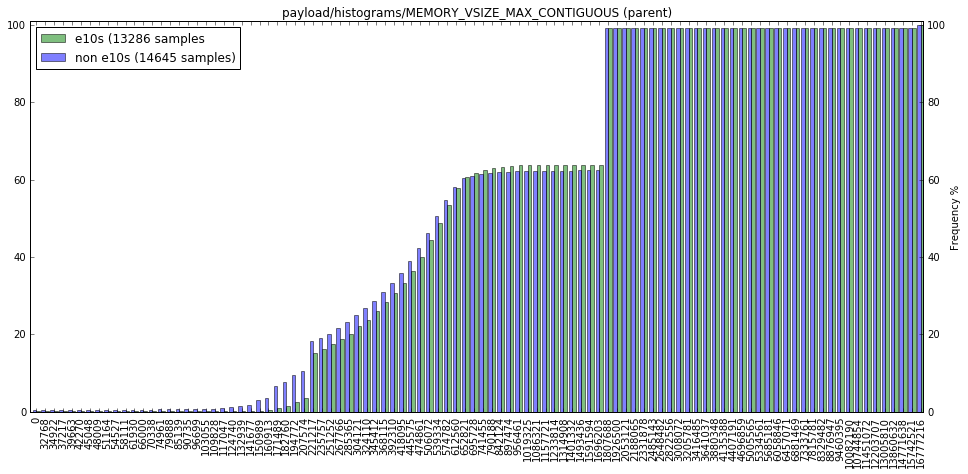

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent) are differing by chance is 0.00.


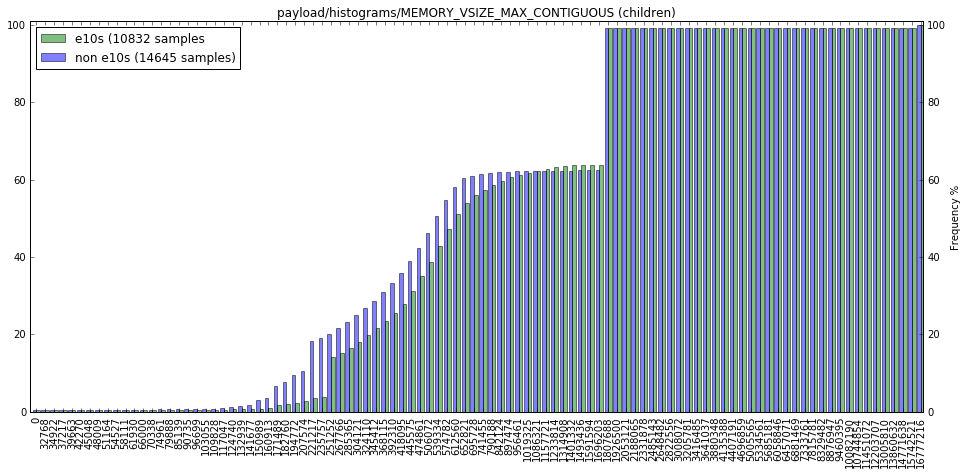

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (children) are differing by chance is 0.00.


In [62]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS",
                   "payload/histograms/MEMORY_HEAP_ALLOCATED",
                   "payload/histograms/MEMORY_JS_GC_HEAP")

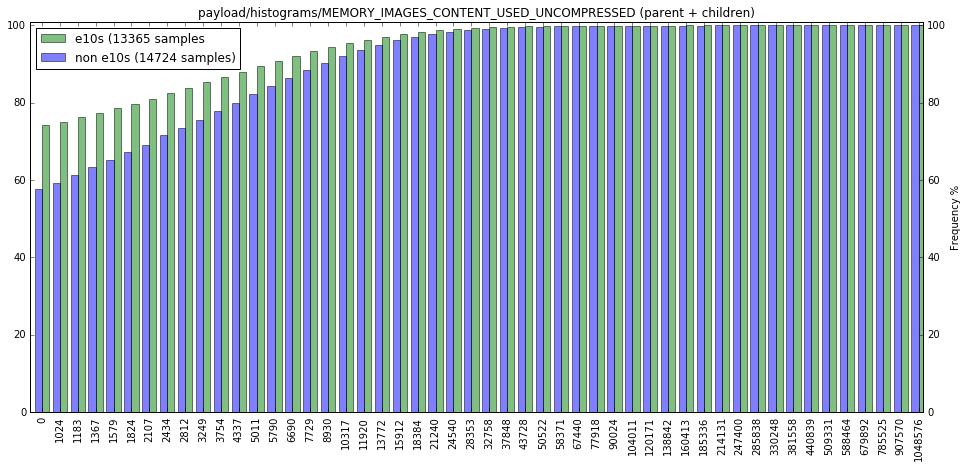

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent + children) are differing by chance is 0.00.


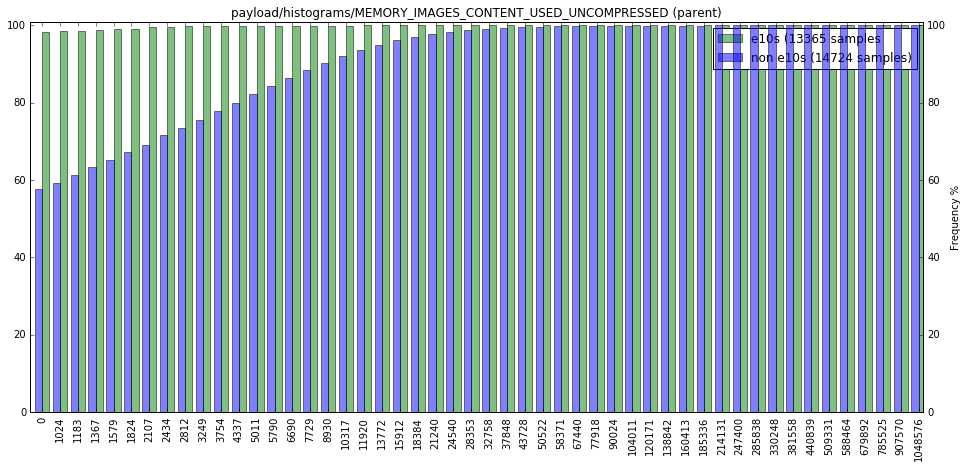

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent) are differing by chance is 0.00.


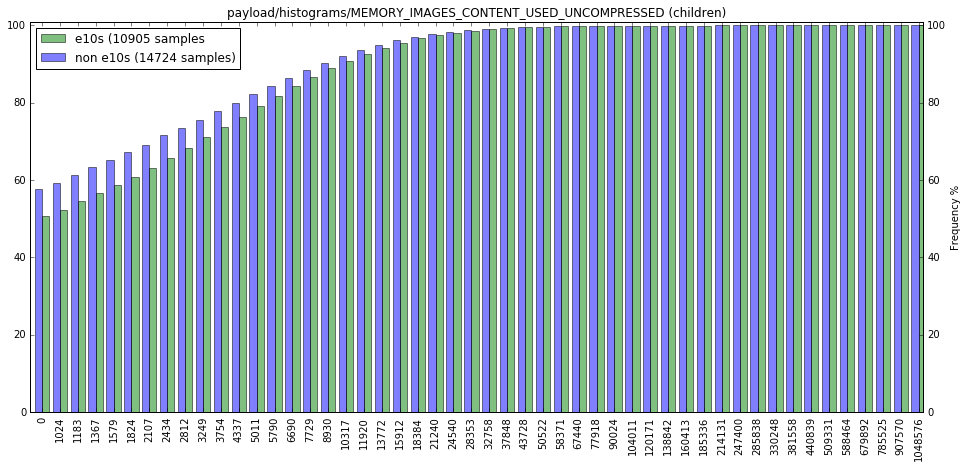

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (children) are differing by chance is 0.00.


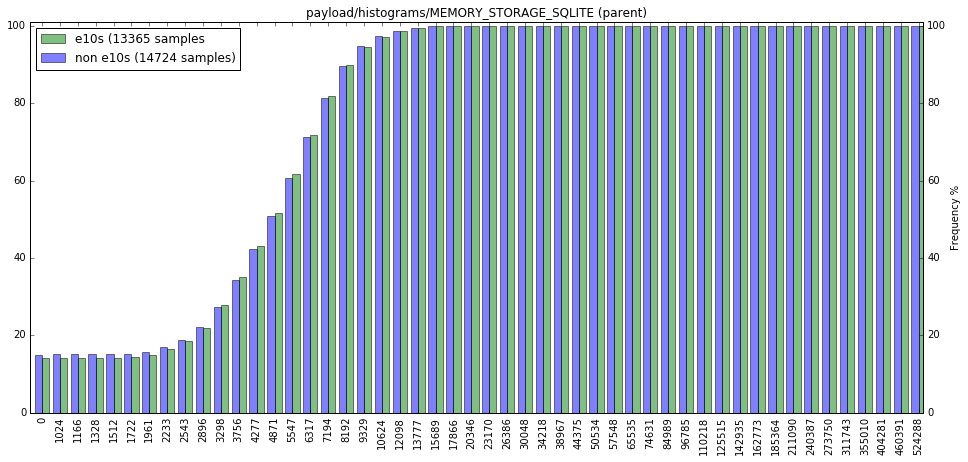

The probability that the distributions for payload/histograms/MEMORY_STORAGE_SQLITE (parent) are differing by chance is 0.02.


In [64]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED",
                   "payload/histograms/MEMORY_STORAGE_SQLITE")

#### c) JS compartments

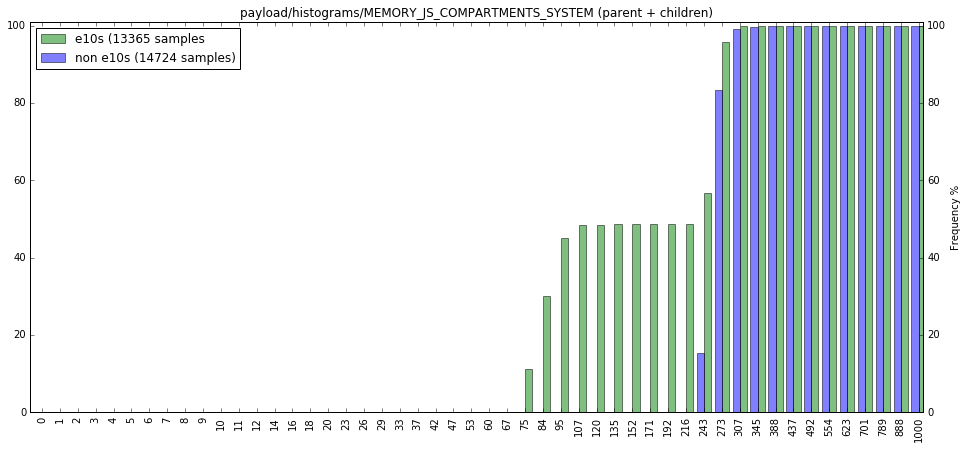

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent + children) are differing by chance is 0.00.


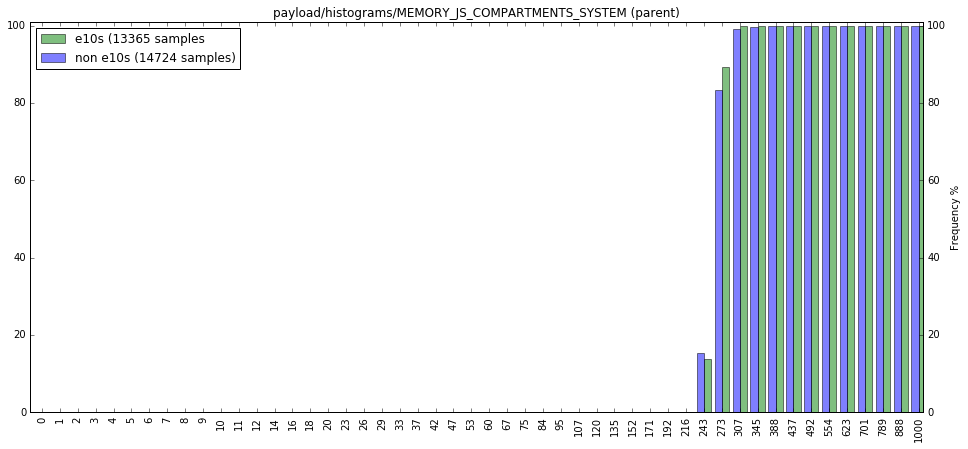

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent) are differing by chance is 0.00.


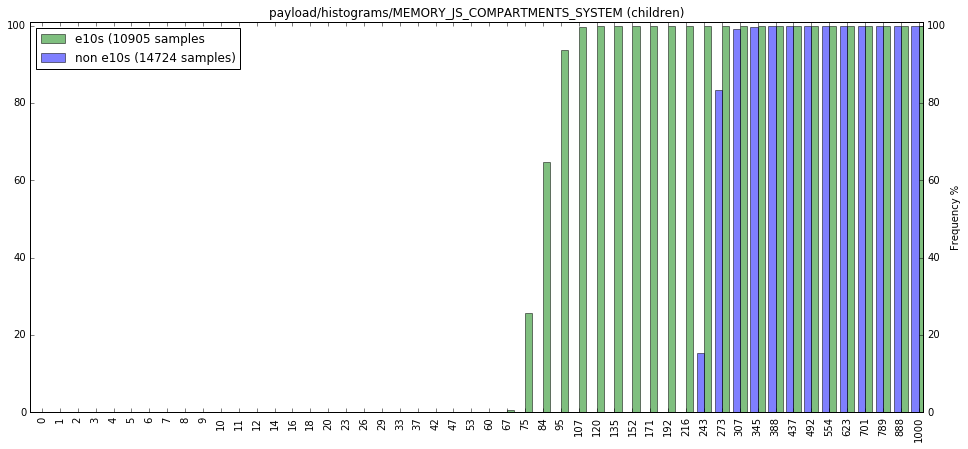

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (children) are differing by chance is 0.00.


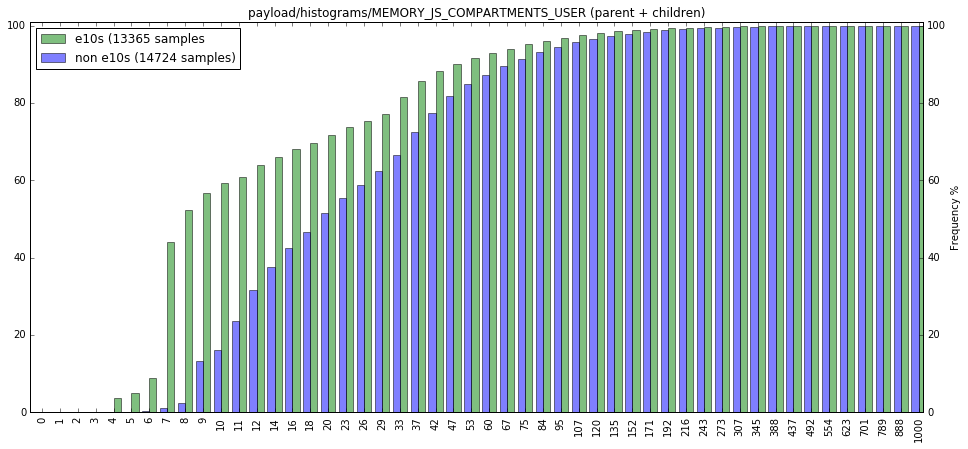

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent + children) are differing by chance is 0.00.


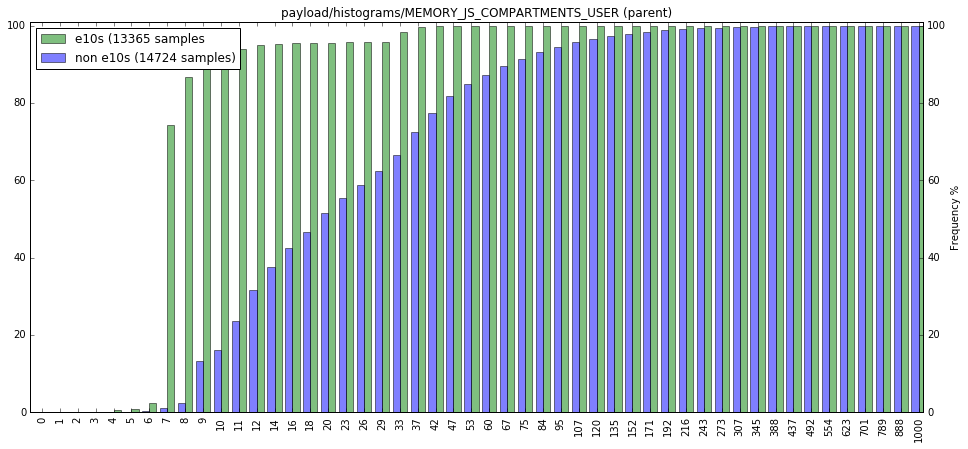

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent) are differing by chance is 0.00.


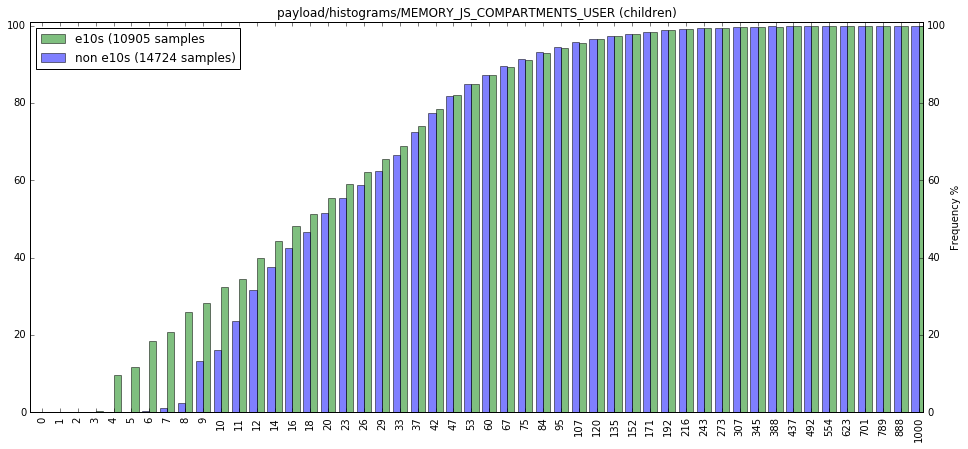

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (children) are differing by chance is 0.00.


In [65]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM",
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_USER")

#### d) Low memory events

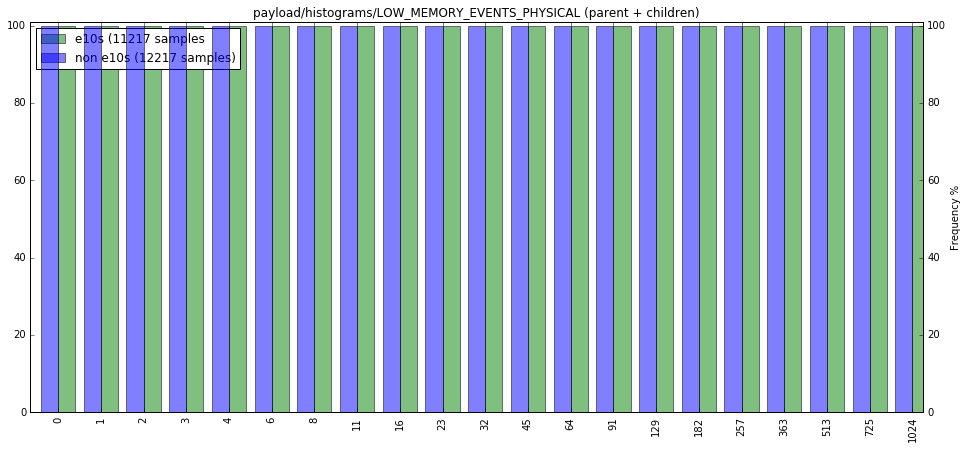

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (parent + children) are differing by chance is 1.00.


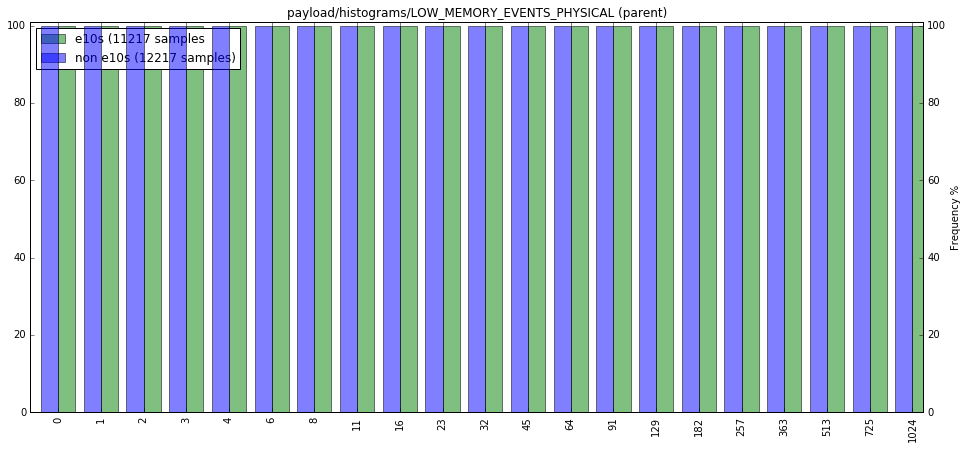

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (parent) are differing by chance is 1.00.


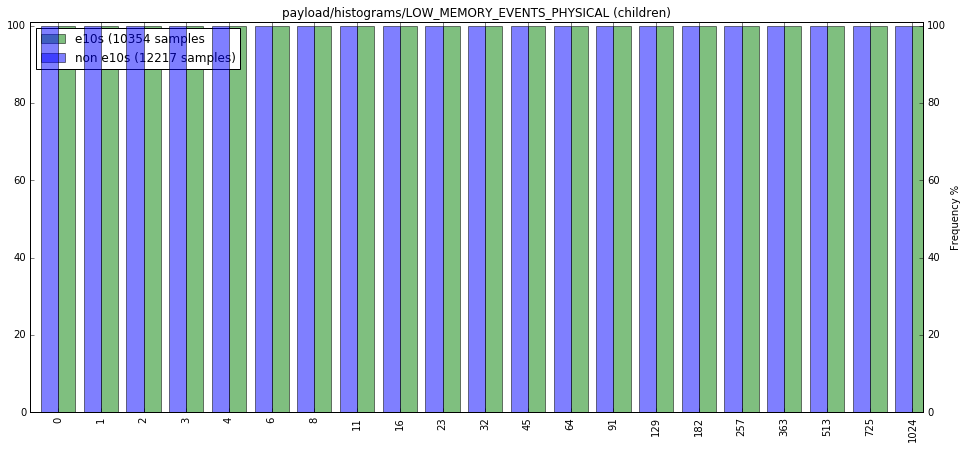

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (children) are differing by chance is 1.00.


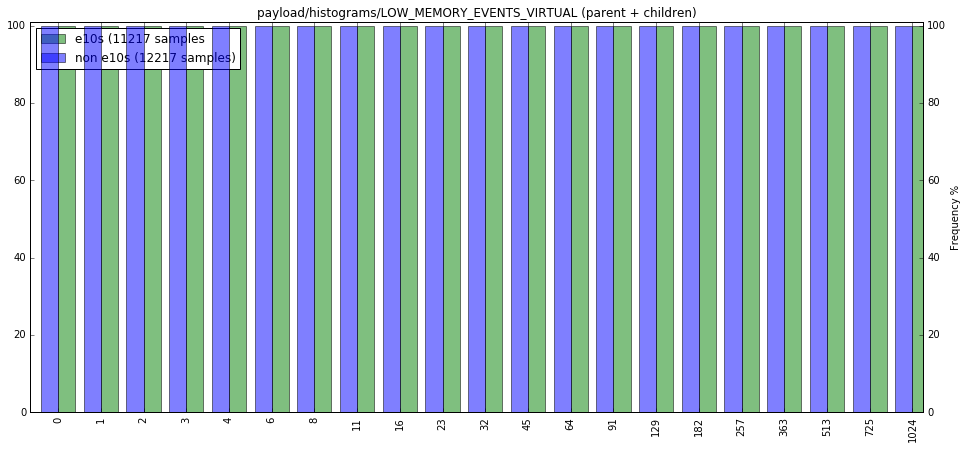

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (parent + children) are differing by chance is 0.04.


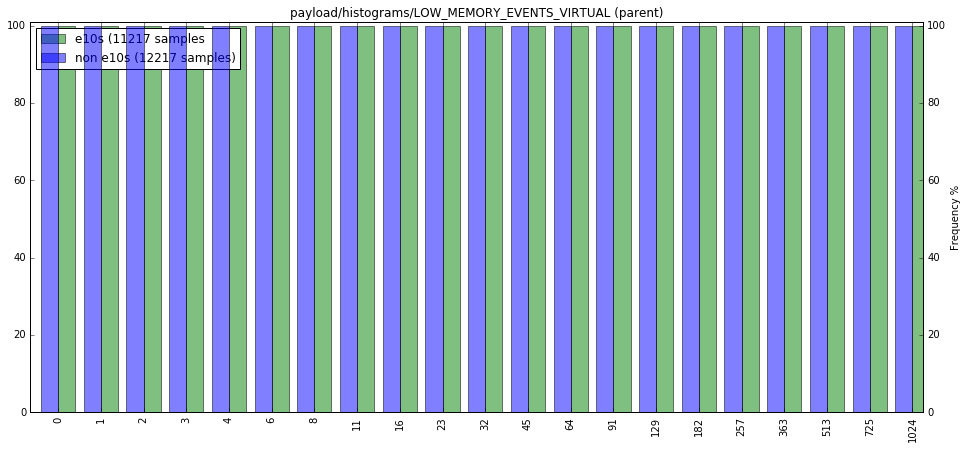

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (parent) are differing by chance is 0.00.


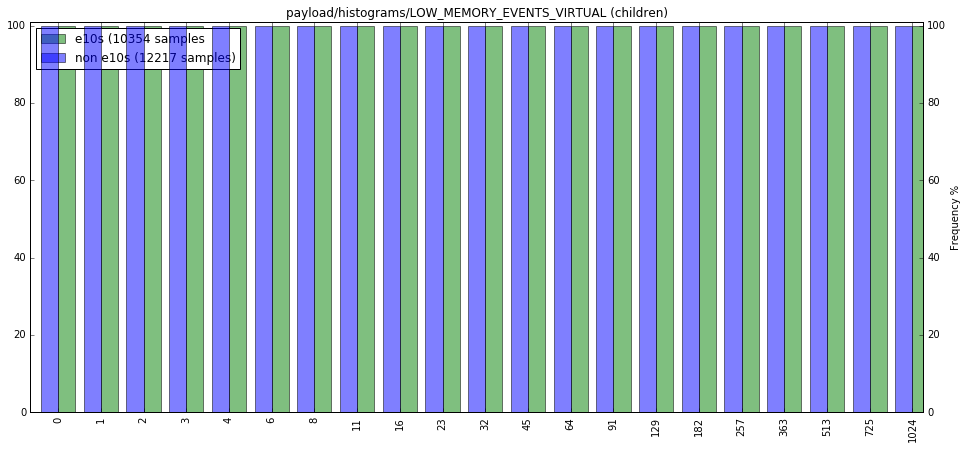

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (children) are differing by chance is 0.22.


In [66]:
compare_histograms(subset,
                   "payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL",
                   "payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL")

#### e) Page faults

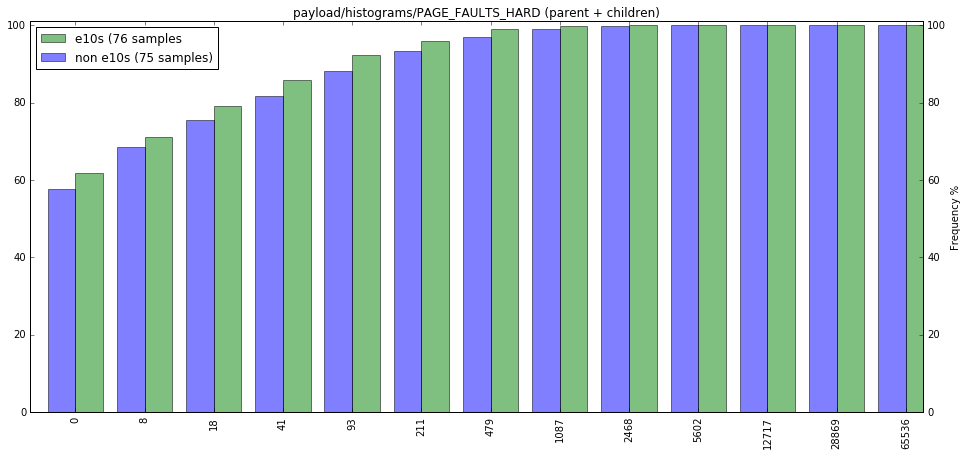

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent + children) are differing by chance is 0.27.


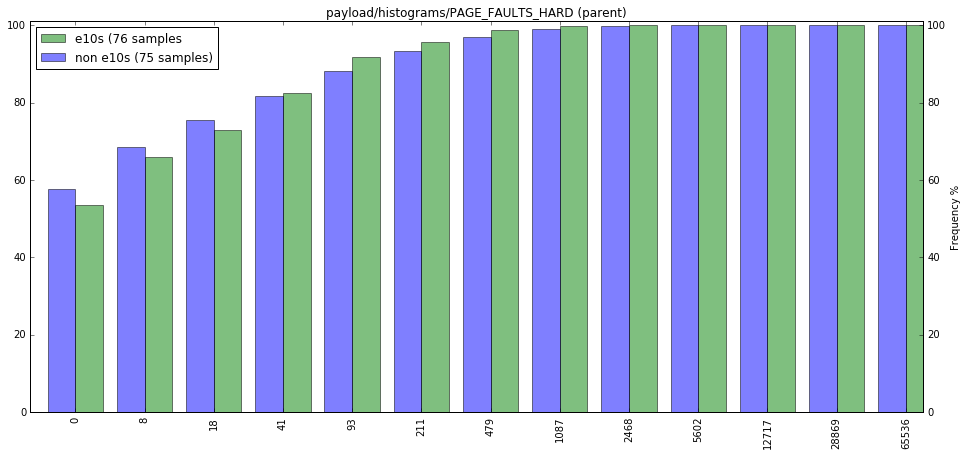

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent) are differing by chance is 0.15.


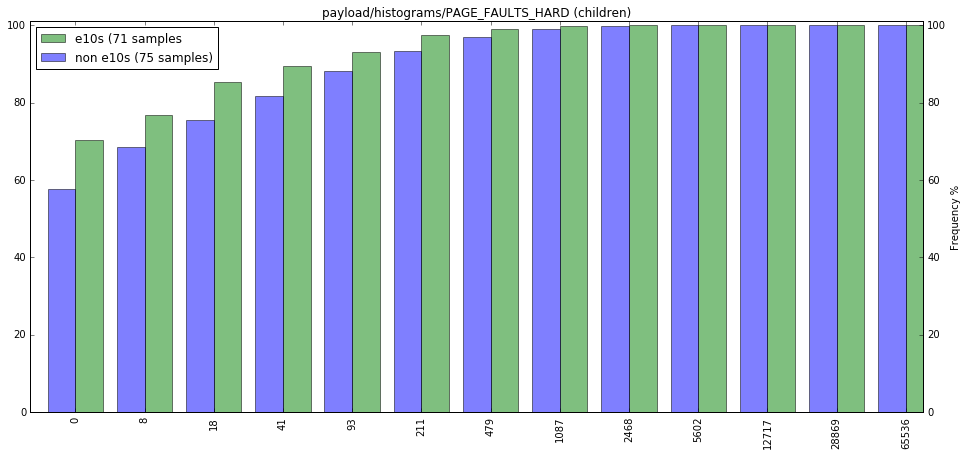

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (children) are differing by chance is 0.00.


In [67]:
compare_histograms(subset,
                   "payload/histograms/PAGE_FAULTS_HARD")

#### f) Ghost windows

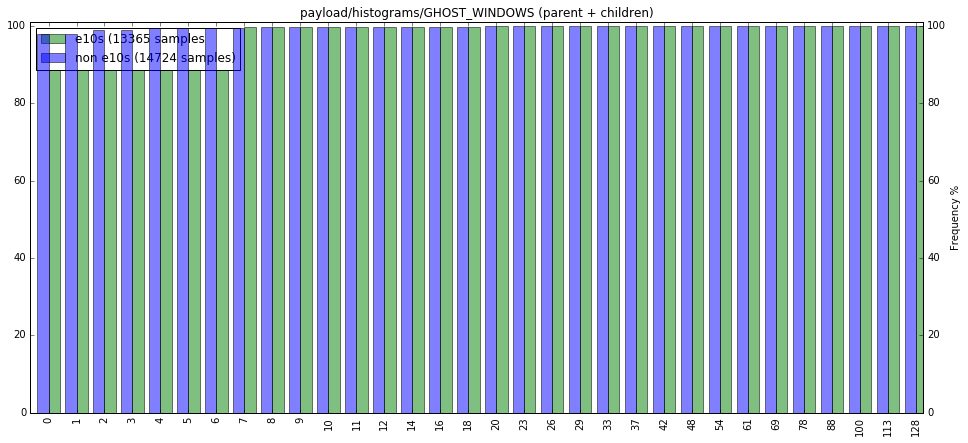

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent + children) are differing by chance is 0.00.


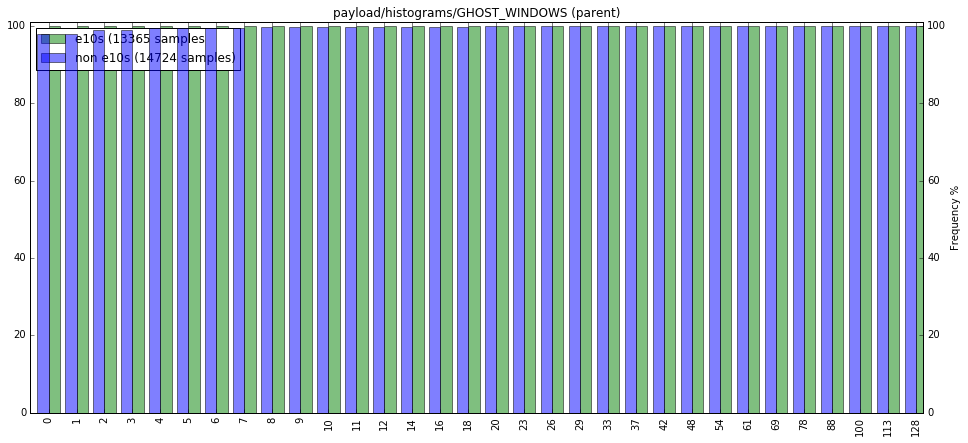

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent) are differing by chance is 0.00.


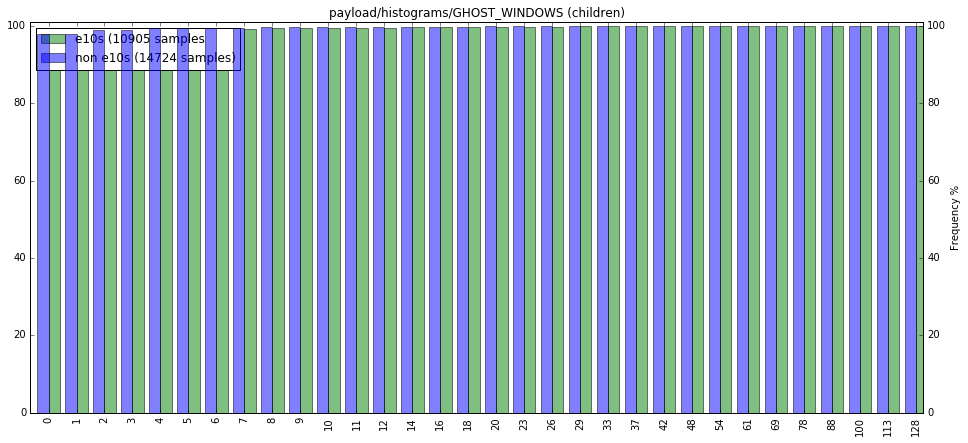

The probability that the distributions for payload/histograms/GHOST_WINDOWS (children) are differing by chance is 0.00.


In [68]:
compare_histograms(subset,
                   "payload/histograms/GHOST_WINDOWS")

## 3. Other

Differences discovered by comparing all histograms (see Bug [1198638](https://bugzilla.mozilla.org/show_bug.cgi?id=1198638))

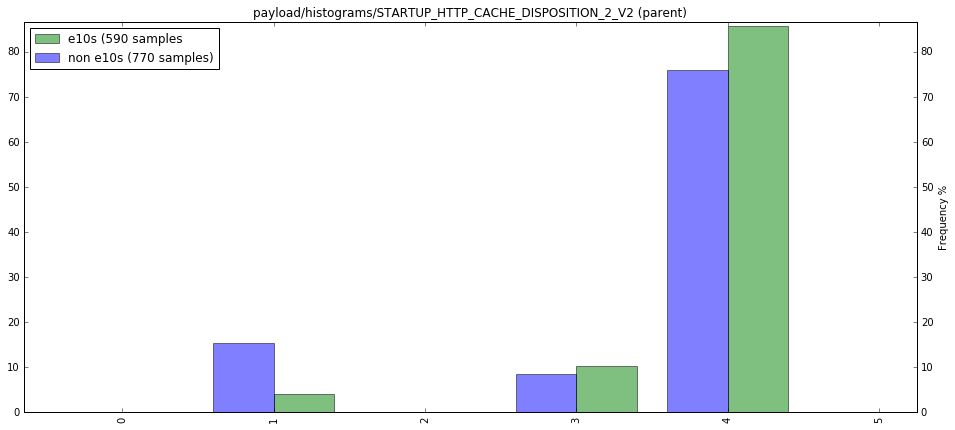

The probability that the distributions for payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2 (parent) are differing by chance is 0.00.


In [69]:
compare_histograms_cdf(False, subset, "payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2")

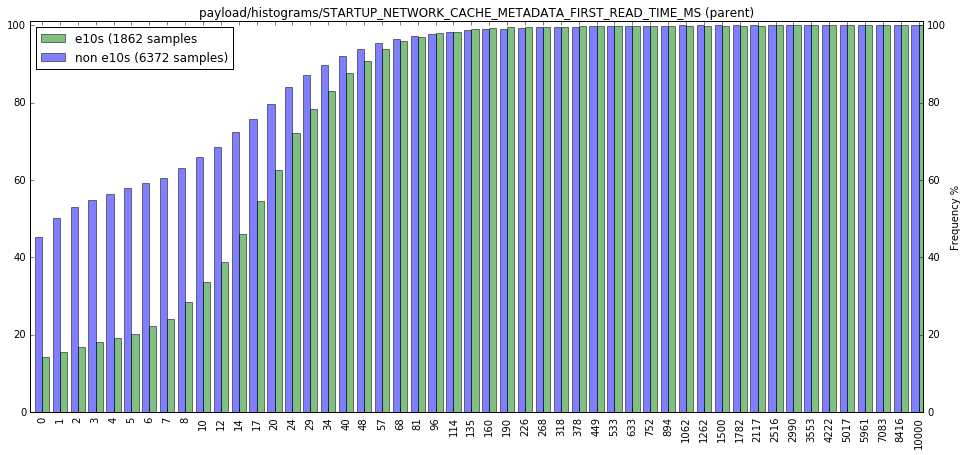

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS (parent) are differing by chance is 0.00.


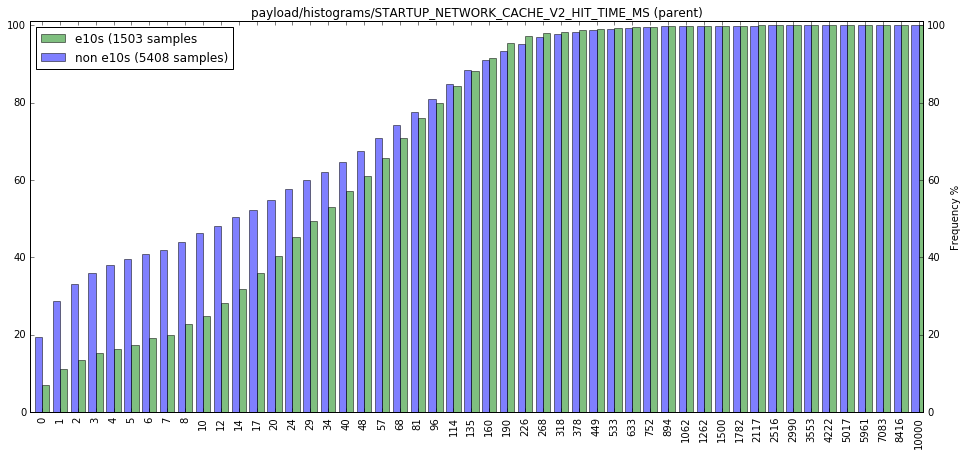

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS (parent) are differing by chance is 0.00.


In [ ]:
compare_histograms(subset,
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS",
                   "payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS")

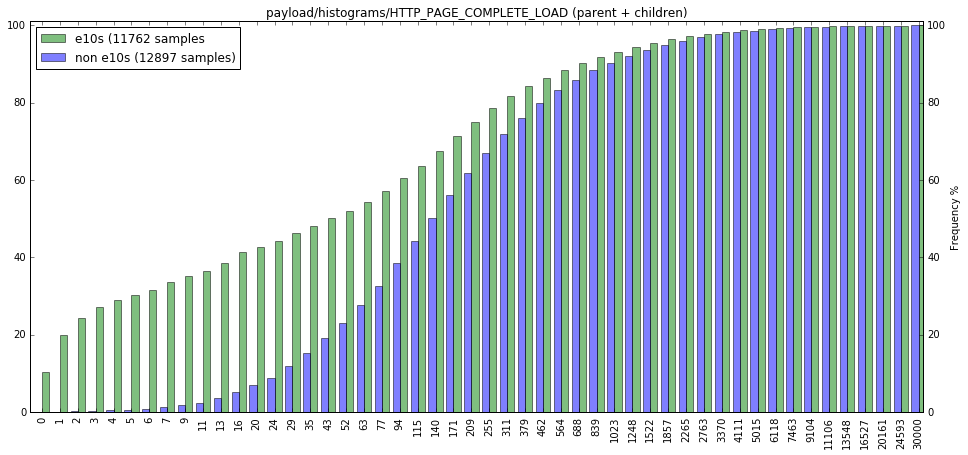

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (parent + children) are differing by chance is 0.00.


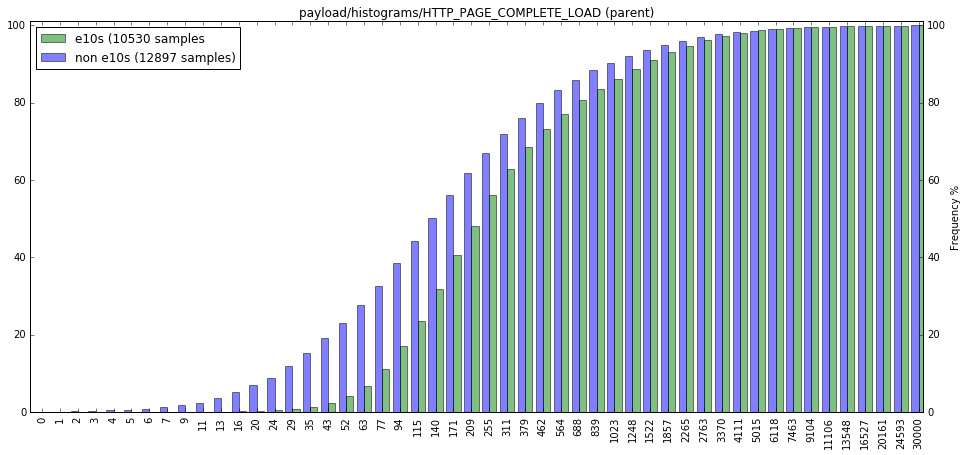

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (parent) are differing by chance is 0.00.


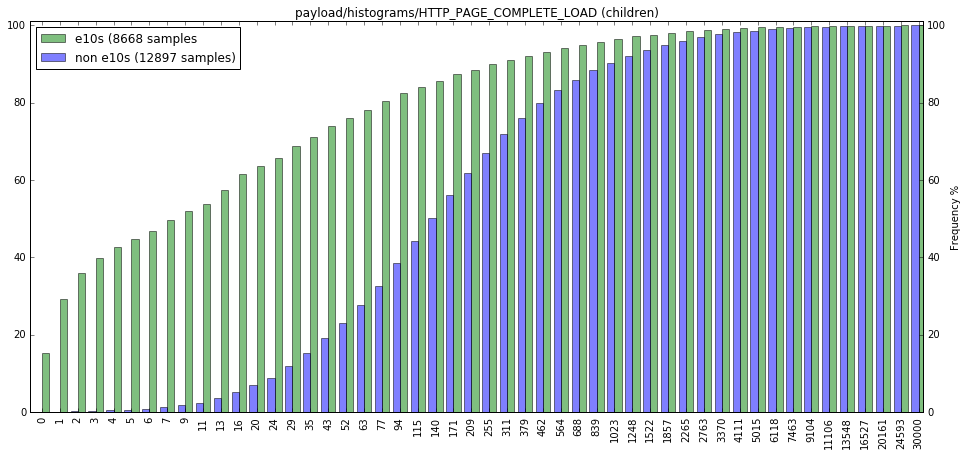

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (children) are differing by chance is 0.00.


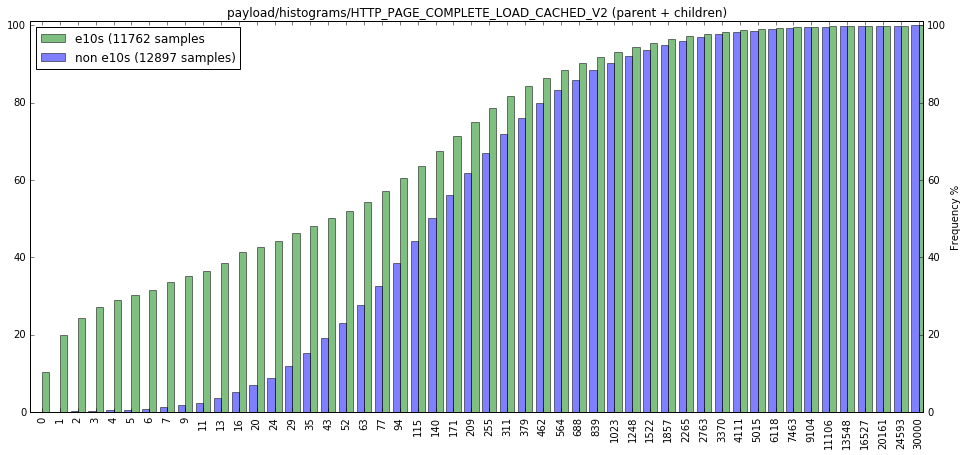

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (parent + children) are differing by chance is 0.00.


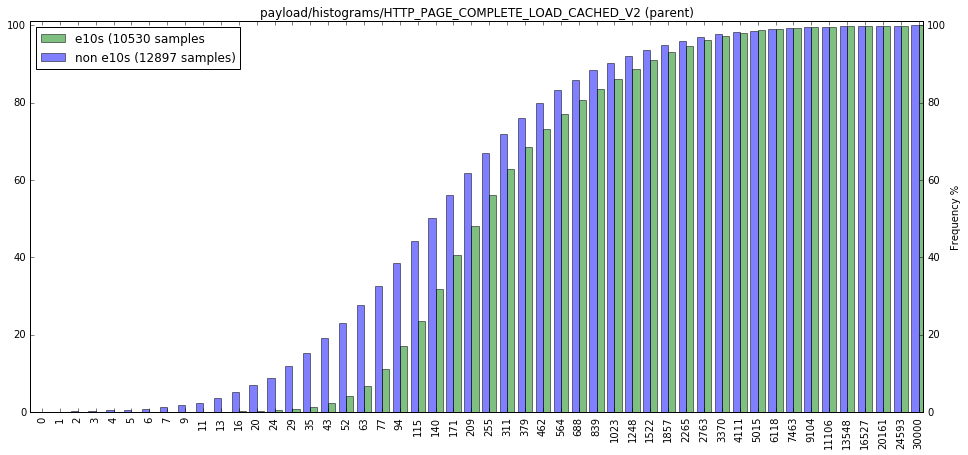

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (parent) are differing by chance is 0.00.


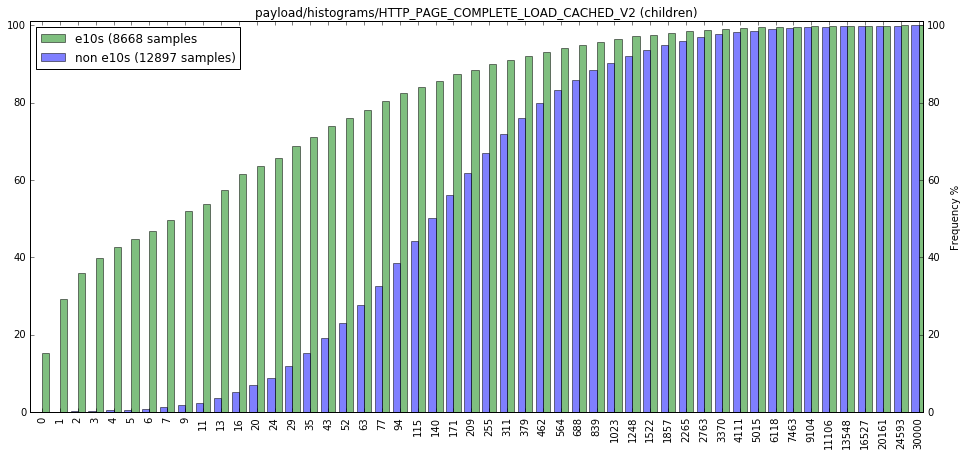

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (children) are differing by chance is 0.00.


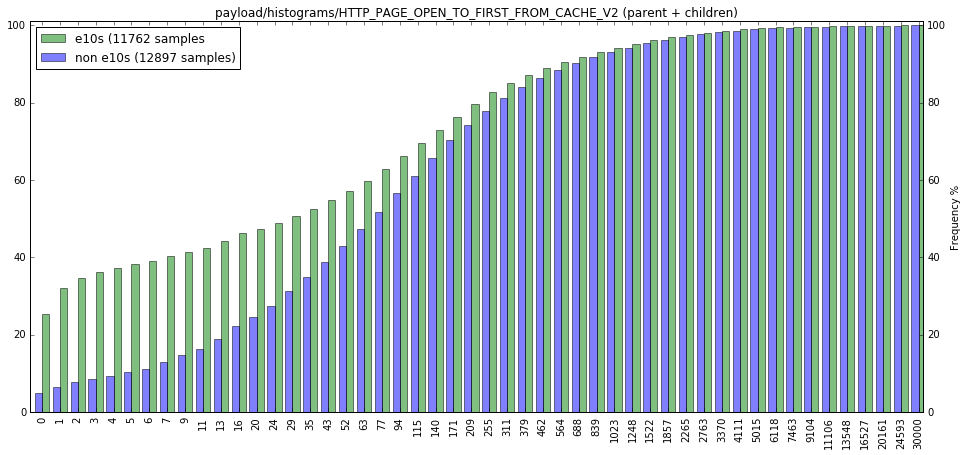

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (parent + children) are differing by chance is 0.00.


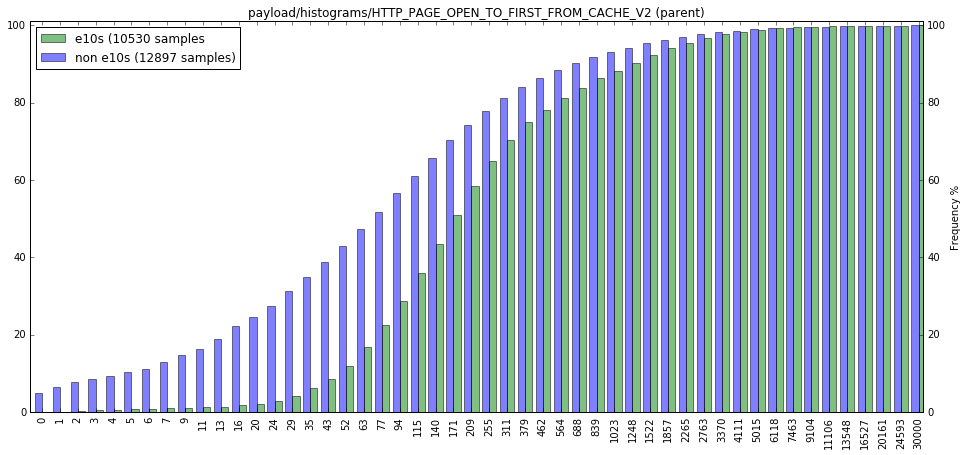

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (parent) are differing by chance is 0.00.


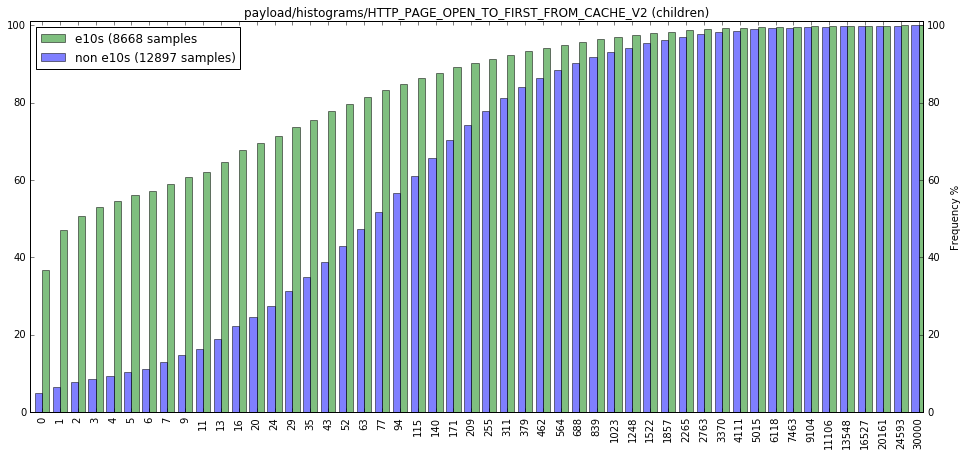

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (children) are differing by chance is 0.00.


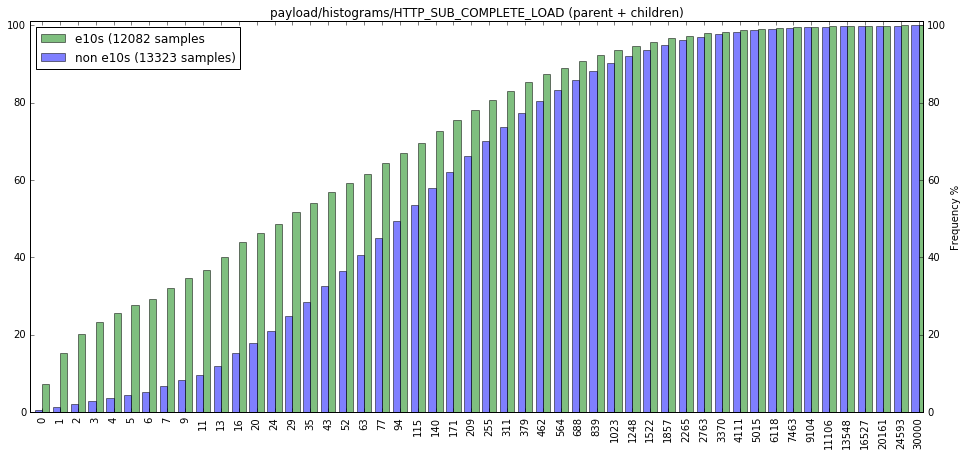

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (parent + children) are differing by chance is 0.00.


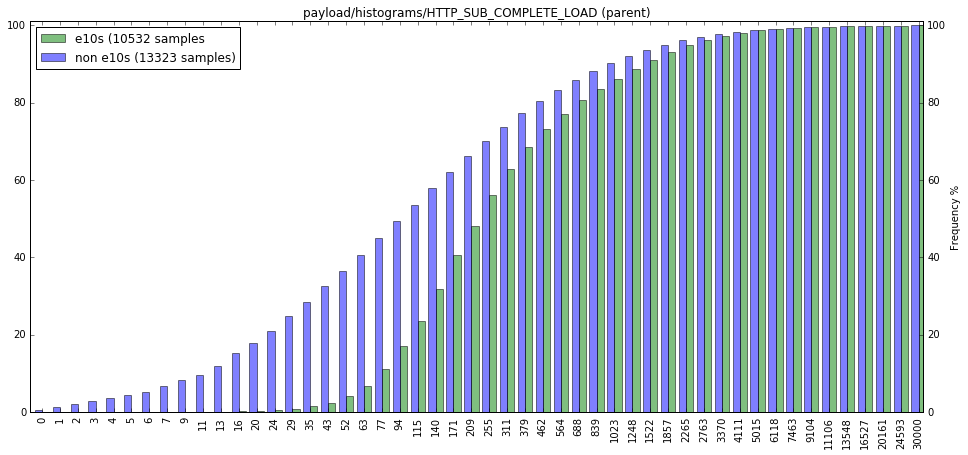

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (parent) are differing by chance is 0.00.


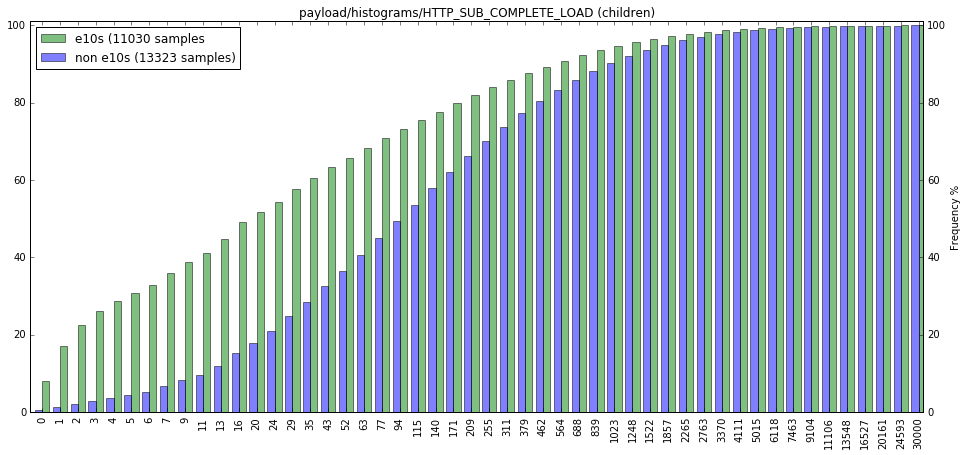

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (children) are differing by chance is 0.00.


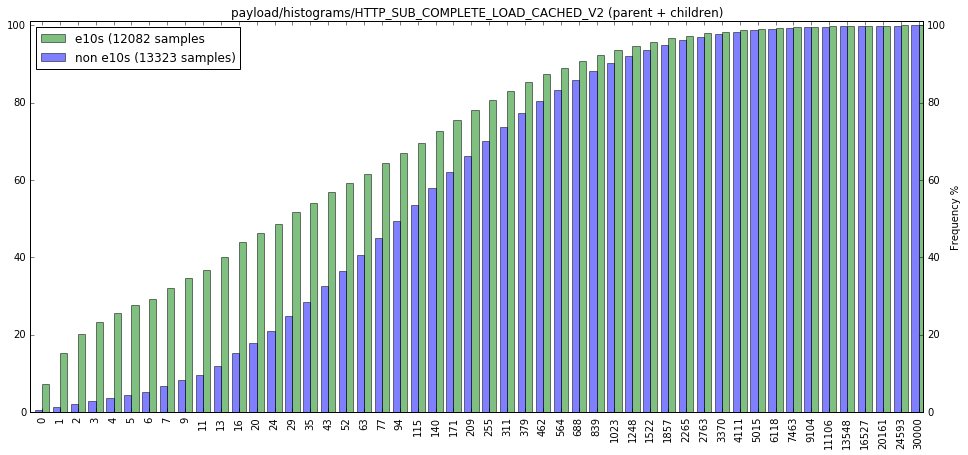

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (parent + children) are differing by chance is 0.00.


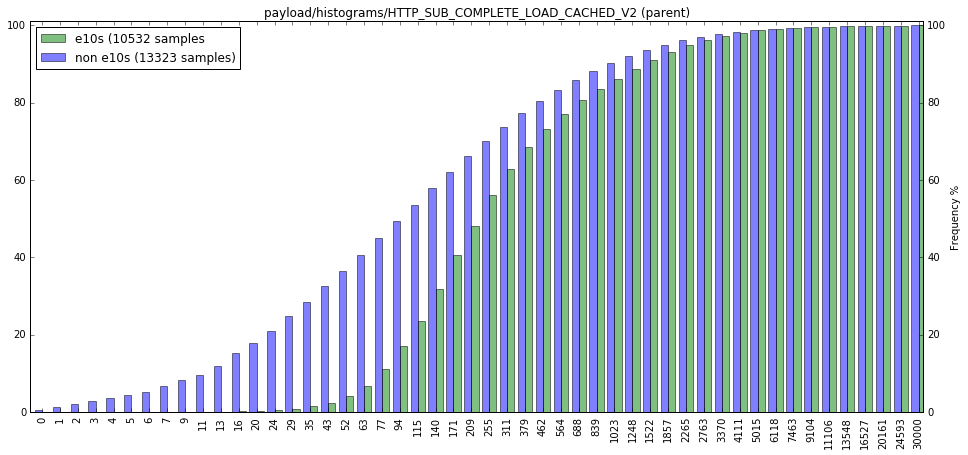

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (parent) are differing by chance is 0.00.


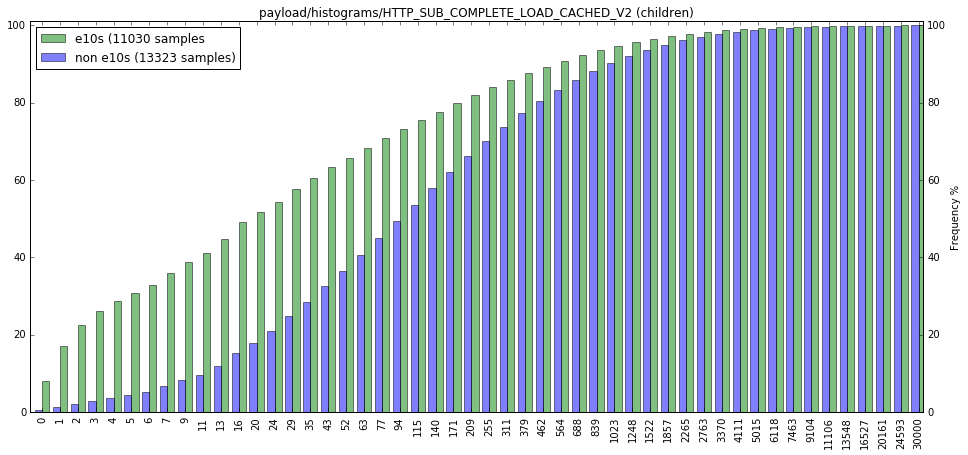

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (children) are differing by chance is 0.00.


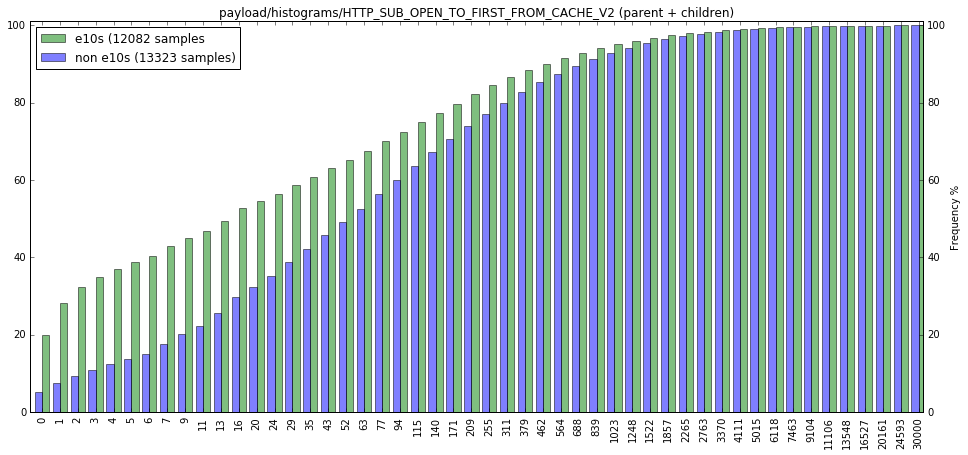

The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (parent + children) are differing by chance is 0.00.


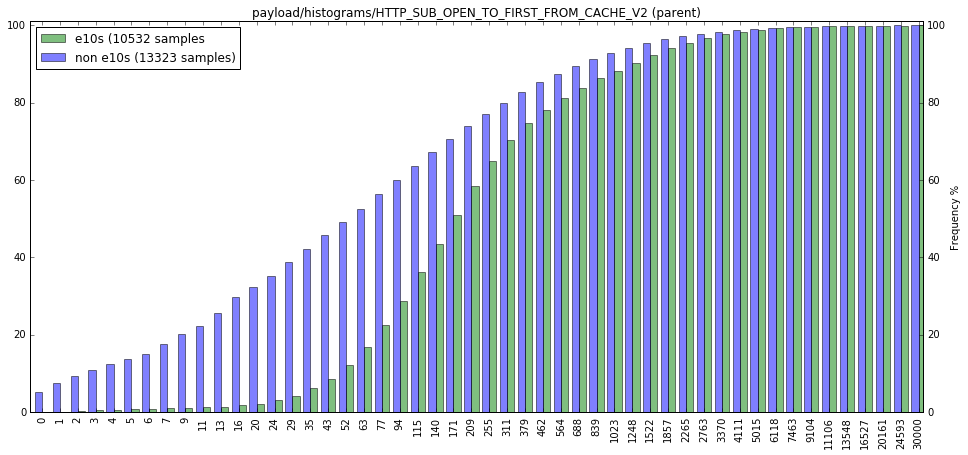

The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (parent) are differing by chance is 0.00.


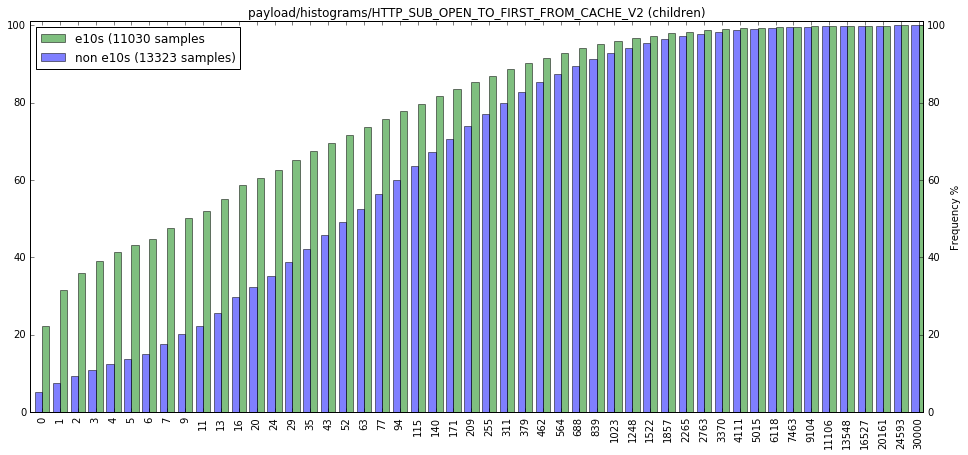

The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (children) are differing by chance is 0.00.


In [ ]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD",                   
                   "payload/histograms/HTTP_SUB_REVALIDATION",
                   "payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/FX_THUMBNAILS_CAPTURE_TIME_MS",                   
                   "payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS",
                   "payload/histograms/FX_SESSION_RESTORE_RESTORE_WINDOW_MS",
                   "payload/histograms/FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY",
                   "payload/histograms/IMAGE_DECODE_SPEED_GIF",
                   "payload/histograms/AUDIOSTREAM_LATER_OPEN_MS",
                   "payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/MEMORY_STORAGE_SQLITE",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS")

In [ ]:
IPython.core.pylabtools.figsize(32, 7)
compare_histograms(subset, 
                   "payload/histograms/CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_SIZE",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE")
IPython.core.pylabtools.figsize(16, 7)

**bug 1226564** - please compare `HTTP_*_COMPLETE_LOAD_NET_V2`

In [ ]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2")

**bug 1255159** - Please look at FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS

In [ ]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")